<a href="https://colab.research.google.com/github/nvssynthesis/essentia2keras/blob/main/essentia2keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yaml
import tensorflow as tf
print('TF = ',tf.__version__)
import numpy as np
# import pickle as pkl
# import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 128
# mpl.rcParams['figure.figsize']= 3*np.array((1.6,1))
import matplotlib.pyplot as plt

tf.config.list_physical_devices()

TF =  2.8.2


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/essentia2keras/'


Mounted at /content/drive


In [ ]:
with open('pluck_culled.yaml', 'r') as file:
  data = yaml.load(file)

In [ ]:
usingBark = False
# inputs X will use 'freqs', 'loudness', 'bark'
freqs = np.array(data.get('lowlevel').get('freqs'))
inharm = np.array(data.get('lowlevel').get('inharmonicity'))
loudness = np.array(data.get('lowlevel').get('loudness'))
rms = np.array(data.get('lowlevel').get('rms'))
cplxty = np.array(data.get('lowlevel').get('spectralComplexity'))
if usingBark:
  barkFeat = np.array(data.get('lowlevel').get('bark'))
else:
  barkFeat = np.array(data.get('lowlevel').get('bfcc'))
  barkFeat = barkFeat[:,1:-1]
spectra = np.array(data.get('lowlevel').get('resampledSpectrum'))
print(barkFeat.shape)
print(spectra.shape)

n_bark = 5 #barkFeat.shape[1]
n_features = 3 + n_bark
n_fft = spectra.shape[1]

for i in np.arange(barkFeat.shape[1]):
  barkMax = max(barkFeat[:,i])
  barkMin = min(barkFeat[:,i])
  barkFeat[:,i] = (barkFeat[:,i] - barkMin) / (barkMax - barkMin)

# check that each used member is of equal length
if (freqs.shape[0] == inharm.shape[0] == loudness.shape[0] == barkFeat.shape[0] == spectra.shape[0]):
  print('sizes correspond.')
  n_data = freqs.shape[0]
else:
  print('SIZES WRONG')

X = np.zeros((n_data, n_features)) #could initialize as NaN or zeros and overwrite instead
Y = np.zeros((n_data, n_fft))

X[:,0] = freqs 
X[:,1] = inharm 
X[:,2] = loudness 
for i in np.arange(n_bark):
  X[:,3+i] = barkFeat[:,i]
# X[:,-1] = cplxty
for i in np.arange(n_fft):
  Y[:, i] = spectra[:,i]

print(X.shape)
print(Y.shape)
print(barkFeat)


(1965, 21)
(1965, 64)
sizes correspond.
(1965, 8)
(1965, 64)
[[0.         0.36160946 0.8334967  ... 0.38971099 0.47090979 0.52473737]
 [0.19805603 0.20699101 0.60601953 ... 0.36013968 0.22145053 0.41134217]
 [0.01588767 0.34504117 0.80662252 ... 0.21234136 0.46301185 0.87690647]
 ...
 [0.         0.36160946 0.8334967  ... 0.38971099 0.47090979 0.52473737]
 [0.         0.36160946 0.8334967  ... 0.38971099 0.47090979 0.52473737]
 [0.         0.36160946 0.8334967  ... 0.38971099 0.47090979 0.52473737]]


0
12


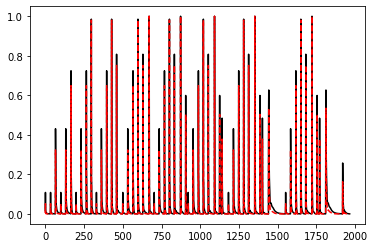

<Figure size 432x288 with 0 Axes>

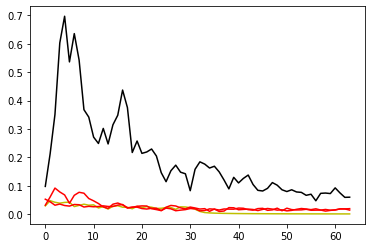

In [ ]:
plt.plot(rms/max(rms),ls='-',c='k')
plt.plot(loudness/max(loudness),ls='--',c='r')
plt.figure()
leastCplx = np.argmin(cplxty)
print(min(cplxty))
print(max(cplxty))
mostCplx = np.argmax(cplxty)
plt.figure()
plt.plot(spectra[leastCplx,:], c='y')
plt.plot(spectra[mostCplx,:], c='k')
plt.plot(spectra[50,:], c='r')
plt.plot(spectra[1140,:], c='r')

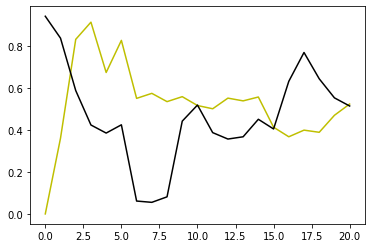

In [ ]:
plt.plot(barkFeat[leastCplx,:],c='y')
plt.plot(barkFeat[mostCplx,:],c='k')

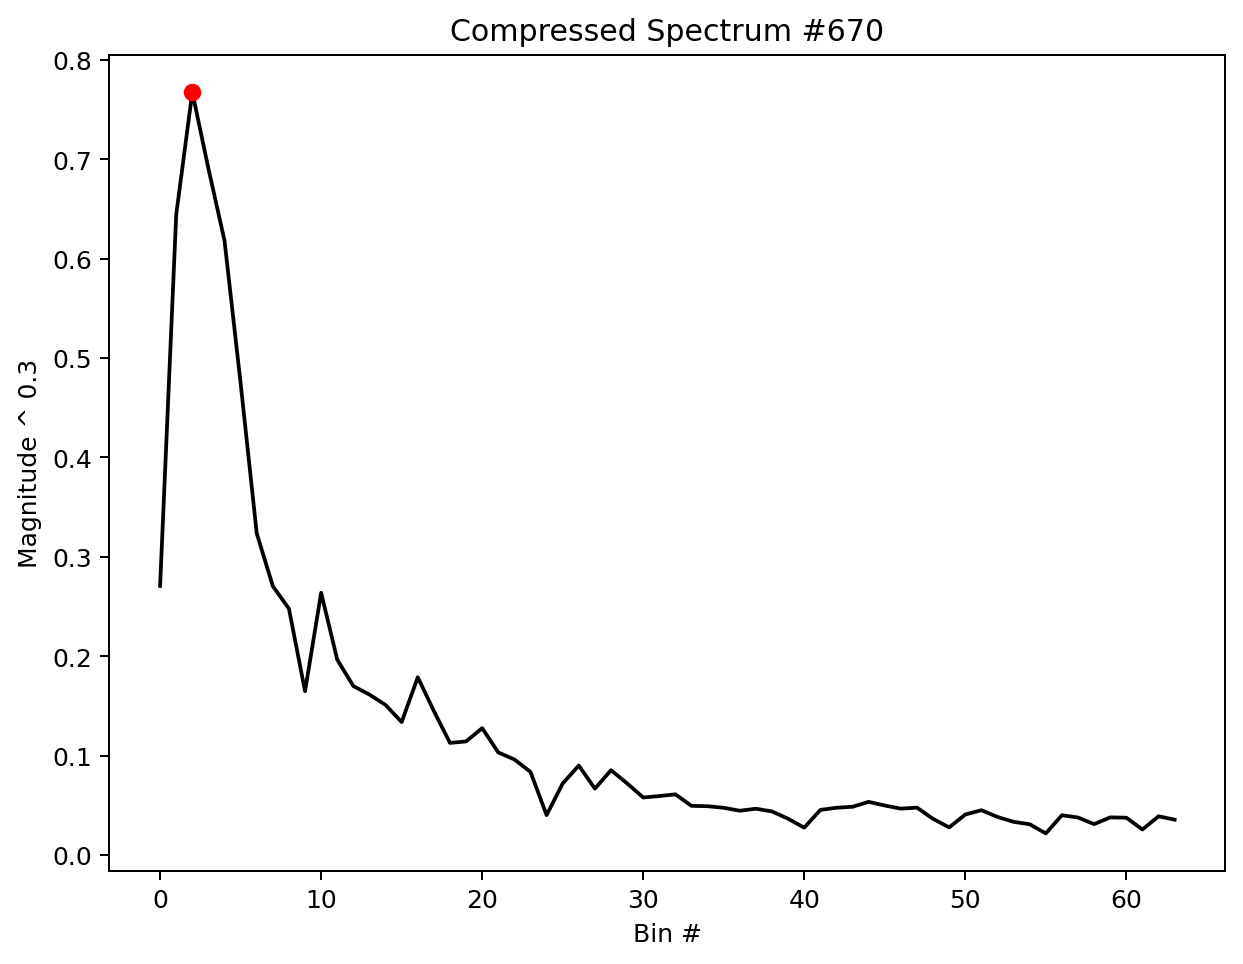

In [ ]:
loudest = np.argmax(loudness)
loudestSpec = spectra[loudest,:]
plt.figure(figsize=(8, 6), dpi=180)
plt.plot(loudestSpec, 'k')
plt.plot([2],loudestSpec[2], 'ro', linewidth=100)
plt.xlabel('Bin #')
plt.ylabel('Magnitude ^ 0.3')
plt.title(f'Compressed Spectrum #{loudest}')
plt.savefig(f'/content/drive/My Drive/essentia2keras/COMPRESSED_SPECTRUM #{loudest}')


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


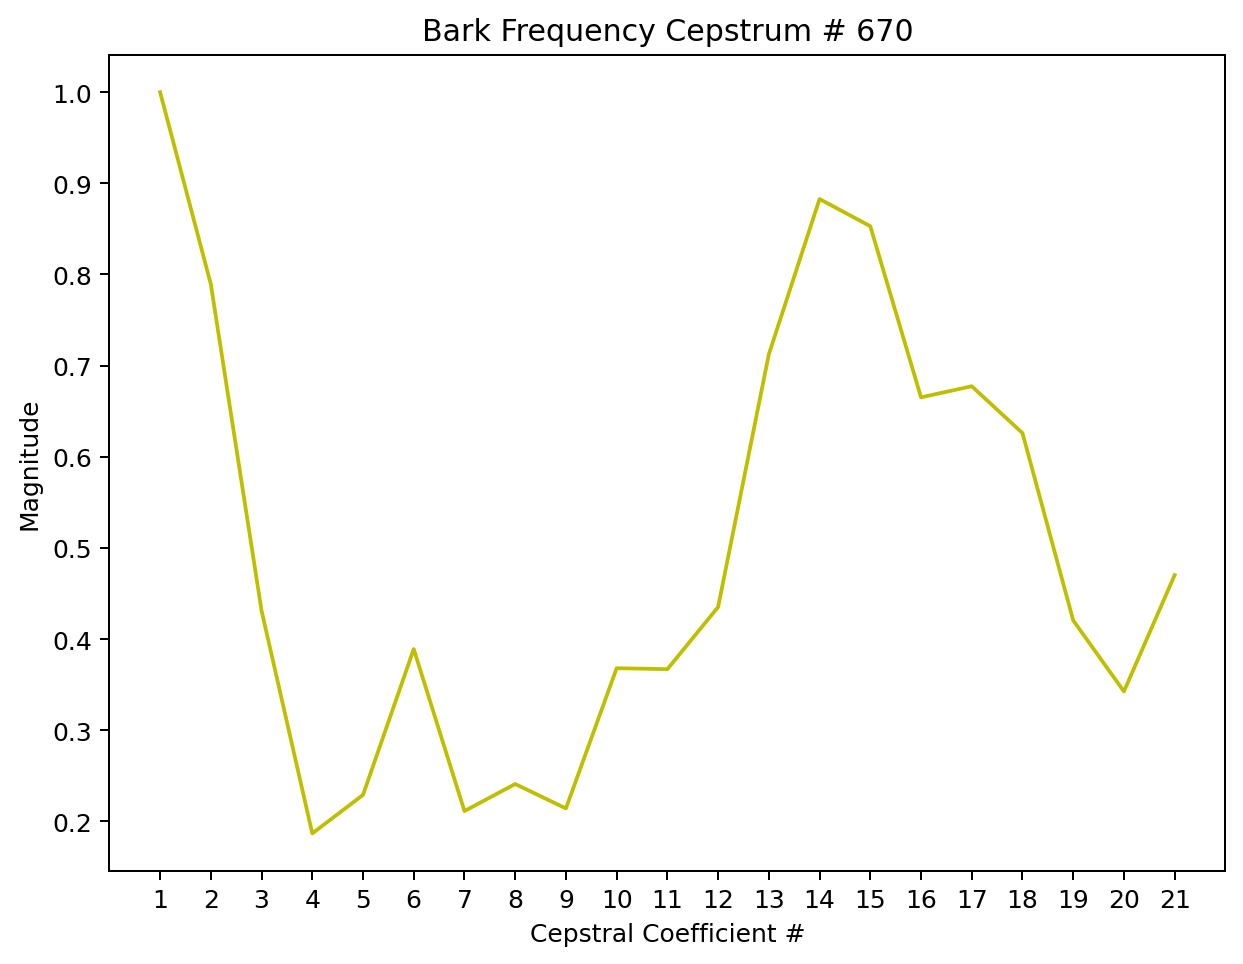

In [ ]:
indices = np.arange(1, 1 + barkFeat.shape[1]).astype(int)
print(indices)

plt.figure(figsize=(8, 6), dpi=180)
loudestBarkFeat = barkFeat[loudest,:]
plt.plot(indices,loudestBarkFeat, 'y')
plt.xticks(indices)
plt.xlabel('Cepstral Coefficient #')
plt.ylabel('Magnitude')
plt.title(f'Bark Frequency Cepstrum # {loudest}')
plt.savefig(f'/content/drive/My Drive/essentia2keras/BFCC #{loudest}')



In [ ]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Activation, BatchNormalization, Normalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam  

In [ ]:
input_dim = X.shape[-1]
output_dim = Y.shape[-1]
input_shape = (input_dim)
output_shape = (output_dim)

dropout_rate = 0.02

#act_fxn = tf.nn.leaky_relu
#act_fxn = 'elu' #'sigmoid' #'relu' # '

# nodes_list = 8*[256]
# nodes_list = 6*[512]
# nodes_list=20,30
nodes_list = 32, 64

kern_init = tf.keras.initializers.glorot_normal
bias_init = tf.keras.initializers.glorot_normal

model = Sequential()
model.add(Input(shape=input_shape))
model.add(BatchNormalization())
for n_nodes in nodes_list:
    model.add(Dense(n_nodes,kernel_initializer=kern_init,bias_initializer=bias_init, activation='tanh'))
#     model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
#    model.add(Activation(act_fxn))
model.add(Dense(output_dim, activation='sigmoid', 
                kernel_initializer=tf.keras.initializers.RandomNormal(mean=1.0, stddev=0.05, seed=None), 
                bias_initializer=tf.keras.initializers.RandomNormal(mean=0.2, stddev=0.05, seed=None)
))
# model.add(Activation('relu'))


In [ ]:
optimizer = Adam(learning_rate=0.0003,beta_1=0.93,beta_2=0.995)
# optimizer = tf.keras.optimizers.SGD( learning_rate=0.01, momentum=0.0, nesterov=False)

loss = tf.keras.losses.mse
# loss = tf.keras.losses.MeanSquaredLogarithmicError()
# def my_loss_fn(y_true, y_pred):
#     squared_difference = tf.square(y_true - y_pred)
#     return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1

# def ESR(y_true, y_pred):


model.compile(loss=loss,
            optimizer=optimizer
             )
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 8)                32        
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 32)                288       
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 64)                2112      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                      

In [ ]:
Y = (Y - min(Y.flatten())) / (max(Y.flatten()) - min(Y.flatten()))

In [ ]:
descr = 'plucked'

np.savetxt(path + descr + 'inputData.txt', X)
np.savetxt(path + descr + 'outputData.txt', Y)

In [ ]:
from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,)
X_train, X_test, Y_train, Y_test , cplxty_train, cplxty_test = train_test_split(X,Y,cplxty, test_size=0.2,)
test_len = X_test.shape[0]


In [ ]:
%pdb off

Automatic pdb calling has been turned OFF


0.8096863698599402
plucked_CplxWgtPow0.08


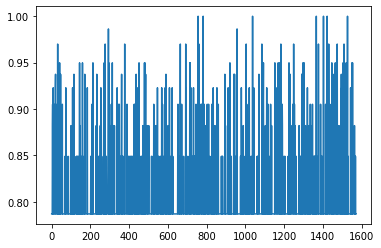

In [ ]:
inverse = False
if inverse: 
  ample_weighting = np.mean(cplxty_train)/(cplxty_train + 1)
else:
  sample_weighting = (cplxty_train)/np.mean(cplxty_train) + 1

expo = .08

sample_weighting = sample_weighting / max(sample_weighting)
sample_weighting = sample_weighting ** expo
plt.plot(sample_weighting)
print(np.mean(sample_weighting))
if inverse:
  ann_suffix = f'{descr}_invCplxWgtPow{expo}'
else:
  ann_suffix = f'{descr}_CplxWgtPow{expo}'
print(ann_suffix)

--------------------------------------------------
Leap 0
Epoch 1/60
13/13 [==============================] - 1s 14ms/step - loss: 0.3591 - val_loss: 0.6616
Epoch 2/60
13/13 [==============================] - 0s 6ms/step - loss: 0.2469 - val_loss: 0.2258
Epoch 3/60
13/13 [==============================] - 0s 5ms/step - loss: 0.0907 - val_loss: 0.0153
Epoch 4/60
13/13 [==============================] - 0s 6ms/step - loss: 0.0173 - val_loss: 0.0042
Epoch 5/60
13/13 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 0.0042
Epoch 6/60
13/13 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0043
Epoch 7/60
13/13 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 8/60
13/13 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0044
Epoch 9/60
13/13 [==============================] - 0s 6ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 10/60
13/13 [==============================] - 0s 5ms

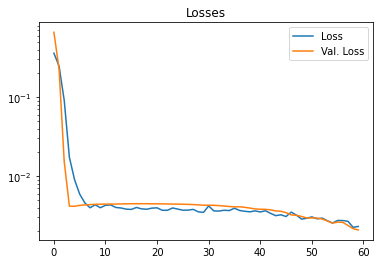

Loss median = 0.003697554115206003
Loss width = 0.000735830282792449
Val. Loss median = 0.004249573219567537
Val. Loss width = 0.0008749450789764524
0


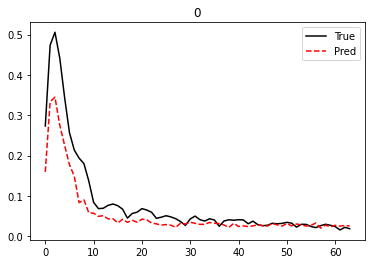

43


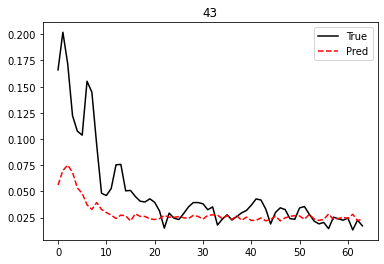

86


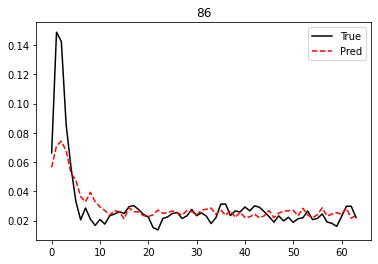

129


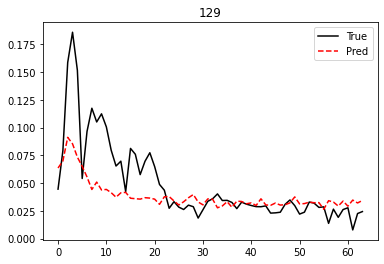

172


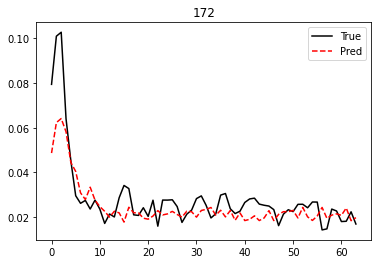

215


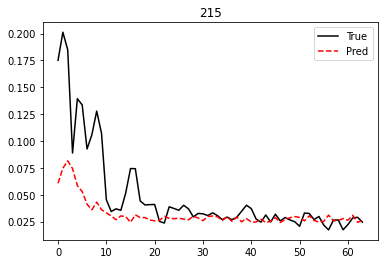

258


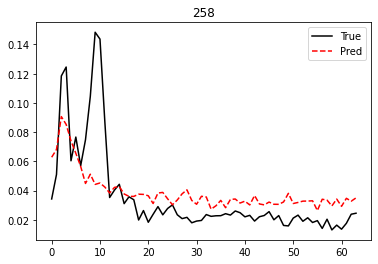

301


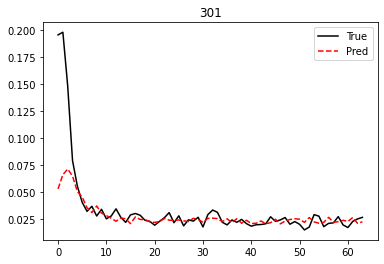

344


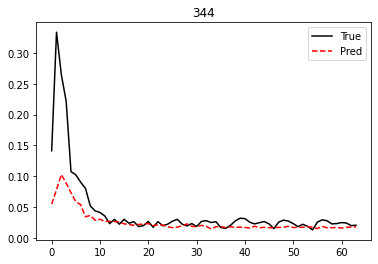

387


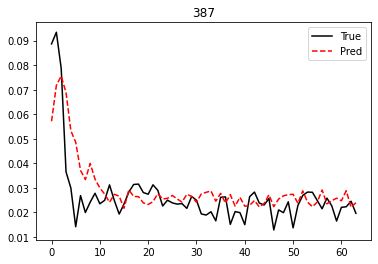

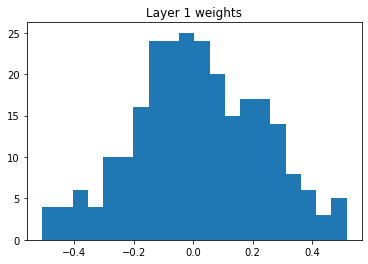

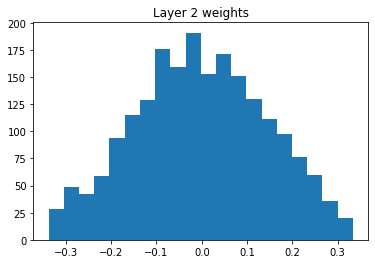

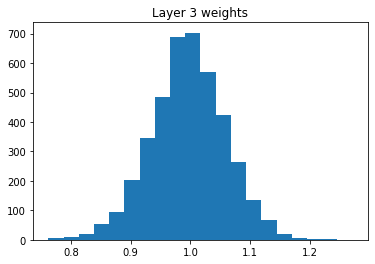

--------------------------------------------------
Leap 1
Epoch 1/60
13/13 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 2/60
13/13 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 3/60
13/13 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 4/60
13/13 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 5/60
13/13 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 6/60
13/13 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 7/60
13/13 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 8/60
13/13 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 9/60
13/13 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 10/60
13/13 [==============================] - 0s 6ms/

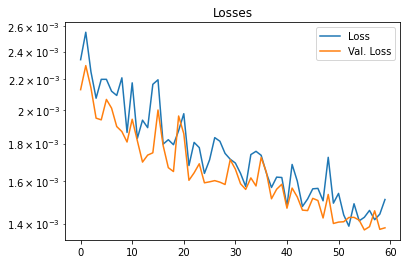

Loss median = 0.0017187680932693183
Loss width = 0.00032246572664007545
Val. Loss median = 0.0015994978602975607
Val. Loss width = 0.00029693348915316164
0


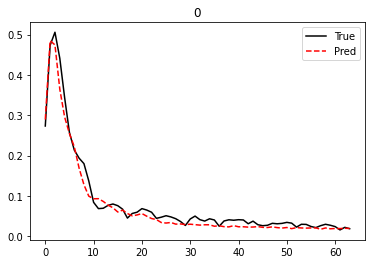

43


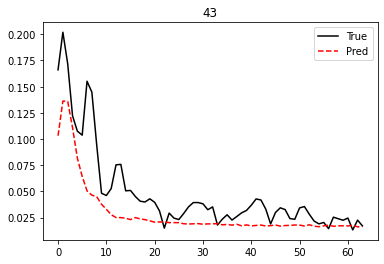

86


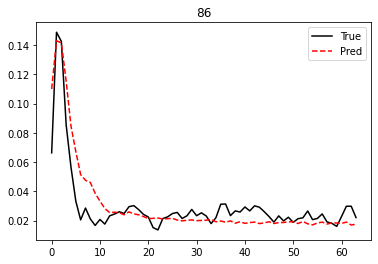

129


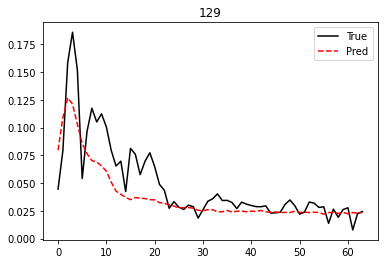

172


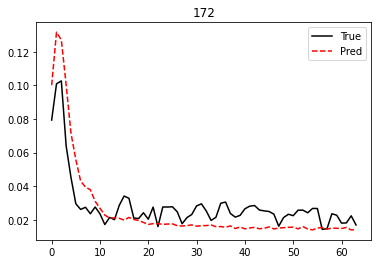

215


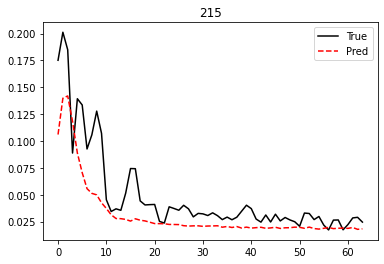

258


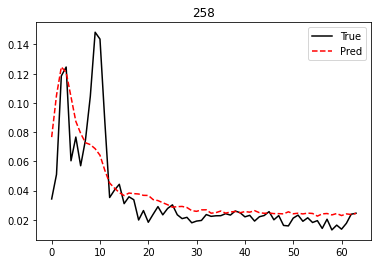

301


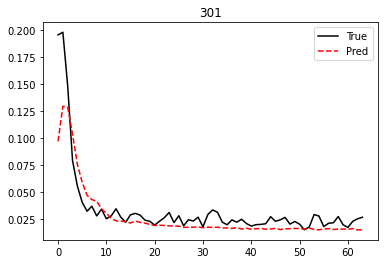

344


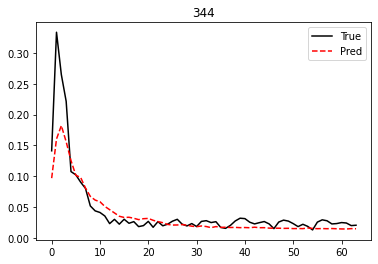

387


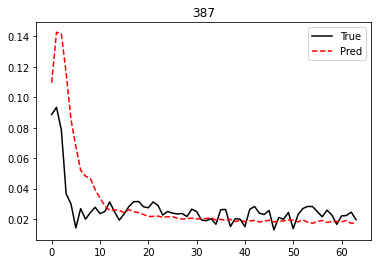

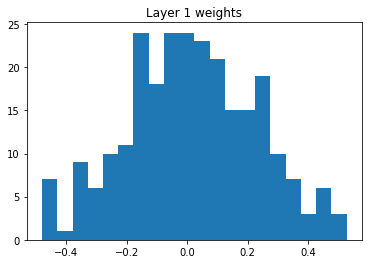

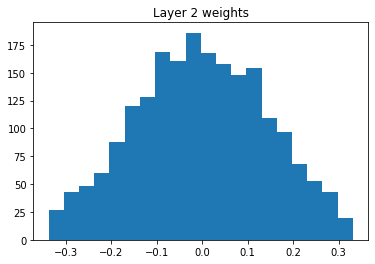

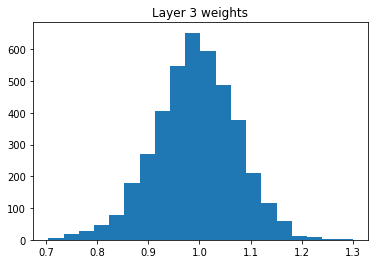

--------------------------------------------------
Leap 2
Epoch 1/60
13/13 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 2/60
13/13 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 3/60
13/13 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/60
13/13 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/60
13/13 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/60
13/13 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/60
13/13 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 8/60
13/13 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/60
13/13 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/60
13/13 [==============================] - 0s 5ms/

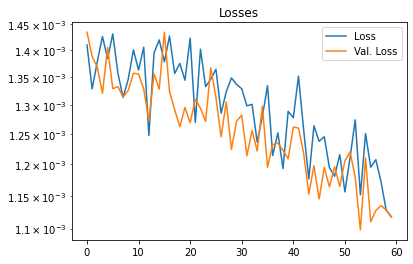

Loss median = 0.0013075064634904265
Loss width = 0.0001257983094546944
Val. Loss median = 0.0012624162482097745
Val. Loss width = 0.00011815852485597134
0


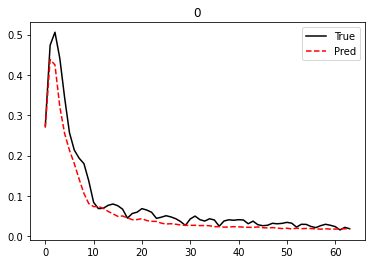

43


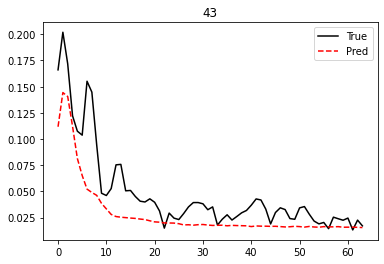

86


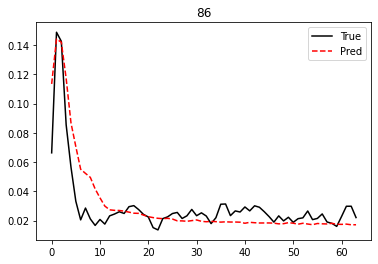

129


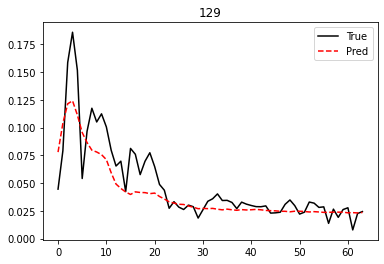

172


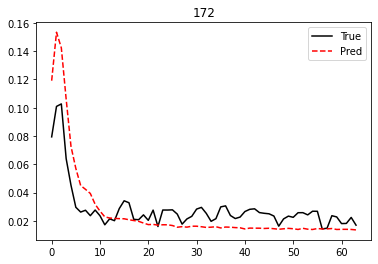

215


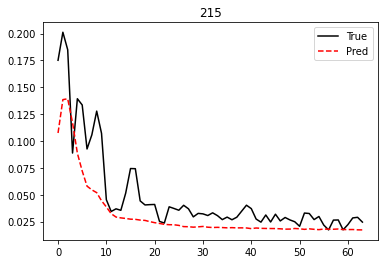

258


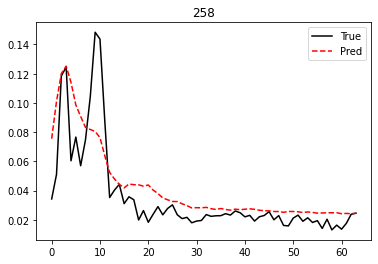

301


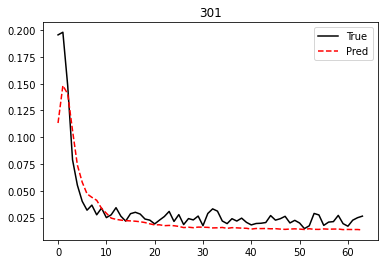

344


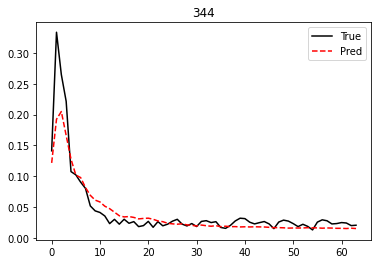

387


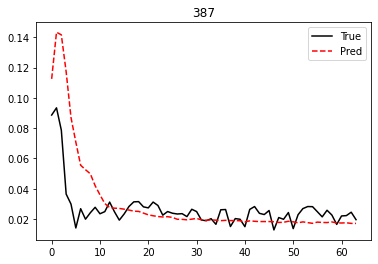

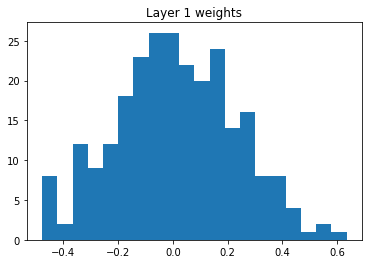

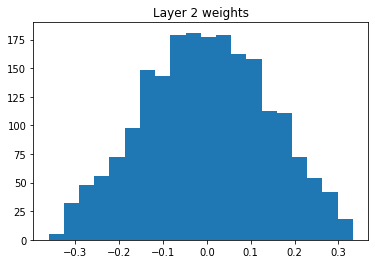

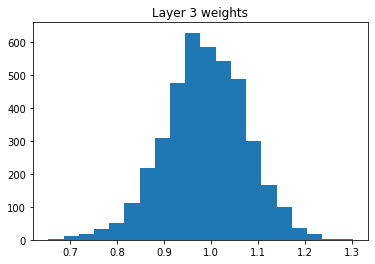

--------------------------------------------------
Leap 3
Epoch 1/60
13/13 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 2/60
13/13 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/60
13/13 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/60
13/13 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5/60
13/13 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/60
13/13 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 7/60
13/13 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/60
13/13 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/60
13/13 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/60
13/13 [==============================] - 0s 7ms/

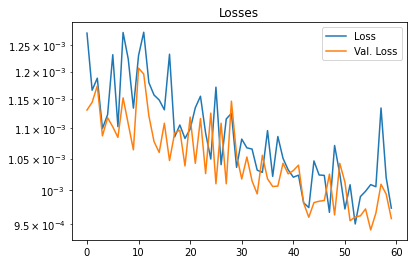

Loss median = 0.0010823767515830696
Loss width = 0.00011135157546959817
Val. Loss median = 0.0010408351081423461
Val. Loss width = 0.00010051543358713388
0


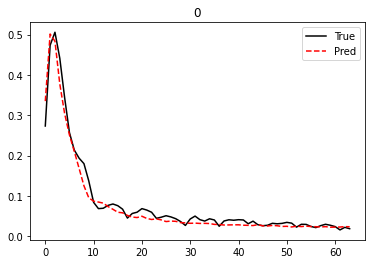

43


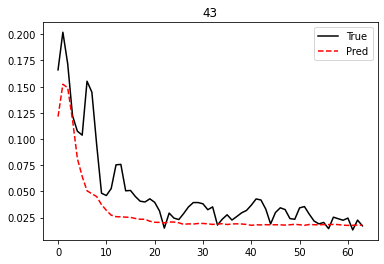

86


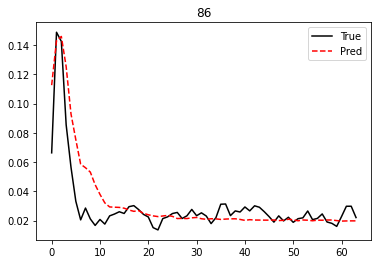

129


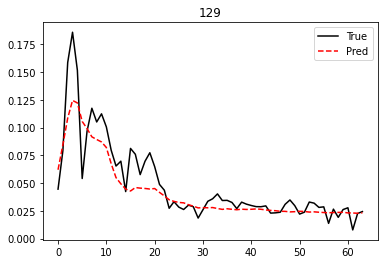

172


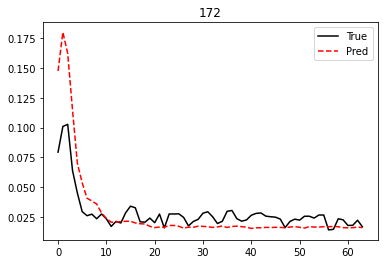

215


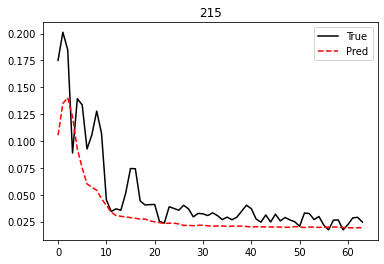

258


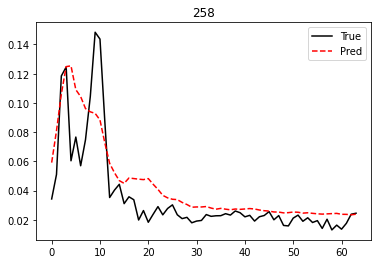

301


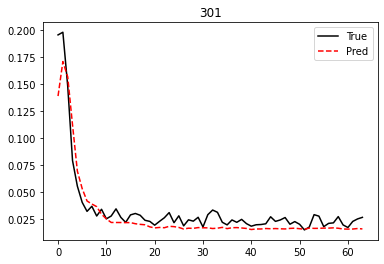

344


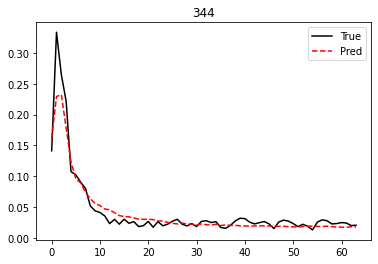

387


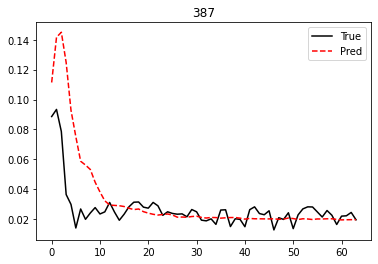

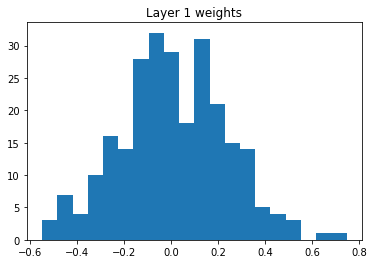

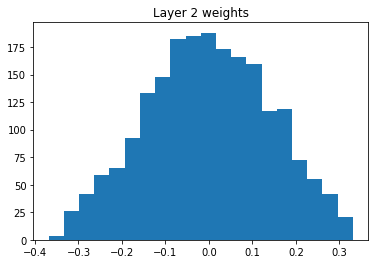

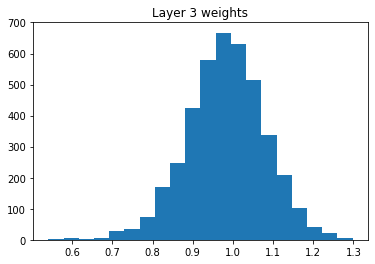

--------------------------------------------------
Leap 4
Epoch 1/60
13/13 [==============================] - 0s 9ms/step - loss: 9.9804e-04 - val_loss: 9.6434e-04
Epoch 2/60
13/13 [==============================] - 0s 7ms/step - loss: 9.7576e-04 - val_loss: 0.0010
Epoch 3/60
13/13 [==============================] - 0s 6ms/step - loss: 9.6605e-04 - val_loss: 9.3966e-04
Epoch 4/60
13/13 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 9.6606e-04
Epoch 5/60
13/13 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 6/60
13/13 [==============================] - 0s 7ms/step - loss: 9.8717e-04 - val_loss: 9.5264e-04
Epoch 7/60
13/13 [==============================] - 0s 7ms/step - loss: 9.9536e-04 - val_loss: 9.4913e-04
Epoch 8/60
13/13 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 9.3930e-04
Epoch 9/60
13/13 [==============================] - 0s 10ms/step - loss: 9.4778e-04 - val_loss: 9.7471e-04
Epoch 1

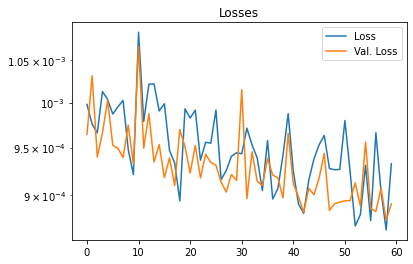

Loss median = 0.0009455132239963859
Loss width = 5.9259808040224016e-05
Val. Loss median = 0.000920894555747509
Val. Loss width = 4.7611043555662036e-05
0


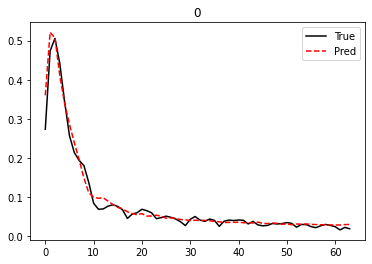

43


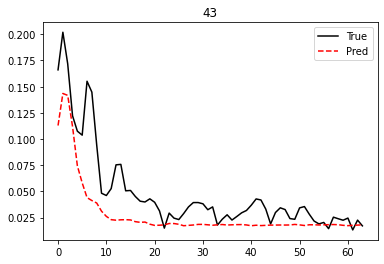

86


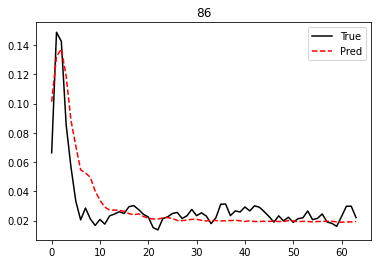

129


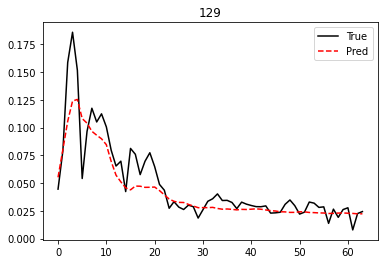

172


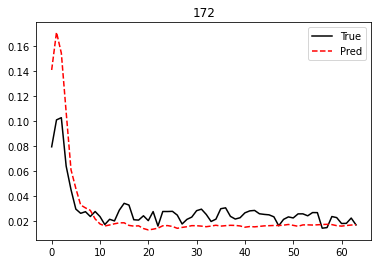

215


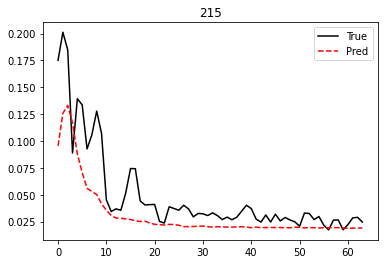

258


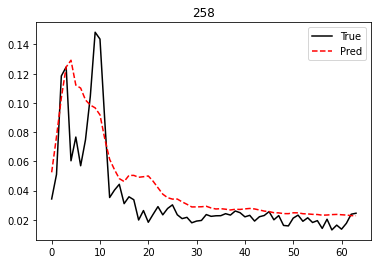

301


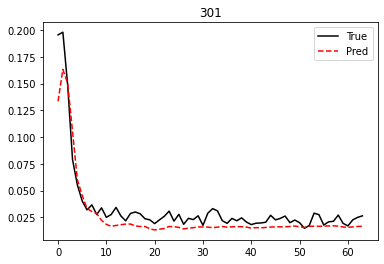

344


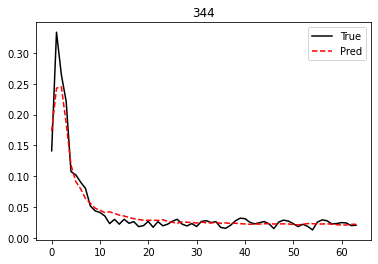

387


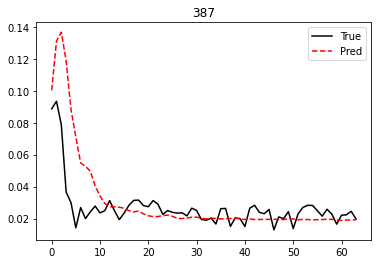

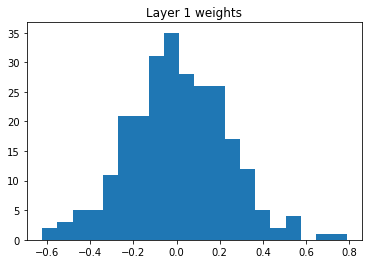

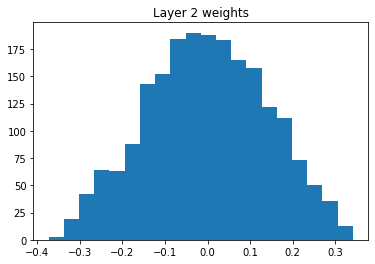

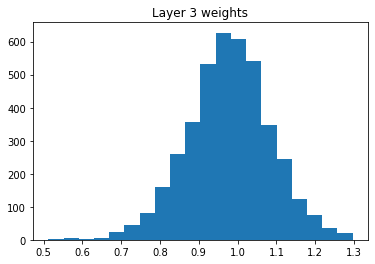

--------------------------------------------------
Leap 5
Epoch 1/60
13/13 [==============================] - 0s 9ms/step - loss: 8.7528e-04 - val_loss: 8.7392e-04
Epoch 2/60
13/13 [==============================] - 0s 8ms/step - loss: 9.3677e-04 - val_loss: 8.9467e-04
Epoch 3/60
13/13 [==============================] - 0s 8ms/step - loss: 9.2100e-04 - val_loss: 8.8424e-04
Epoch 4/60
13/13 [==============================] - 0s 9ms/step - loss: 8.7602e-04 - val_loss: 8.8139e-04
Epoch 5/60
13/13 [==============================] - 0s 7ms/step - loss: 8.5276e-04 - val_loss: 8.9522e-04
Epoch 6/60
13/13 [==============================] - 0s 7ms/step - loss: 8.8496e-04 - val_loss: 8.7240e-04
Epoch 7/60
13/13 [==============================] - 0s 8ms/step - loss: 8.8703e-04 - val_loss: 8.8237e-04
Epoch 8/60
13/13 [==============================] - 0s 6ms/step - loss: 8.8684e-04 - val_loss: 8.7076e-04
Epoch 9/60
13/13 [==============================] - 0s 8ms/step - loss: 8.9702e-04 - val_loss:

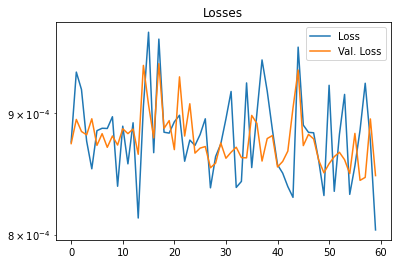

Loss median = 0.0008830057631712407
Loss width = 4.144279228057712e-05
Val. Loss median = 0.0008732983551453799
Val. Loss width = 2.4388558813370764e-05
0


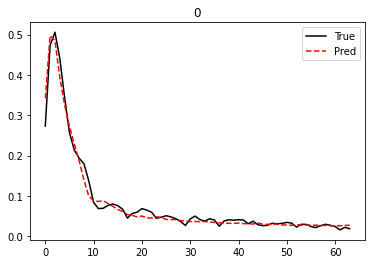

43


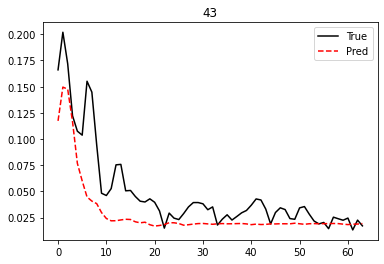

86


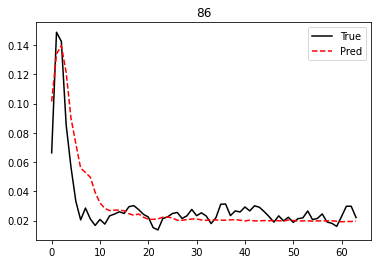

129


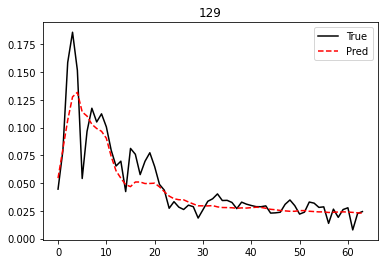

172


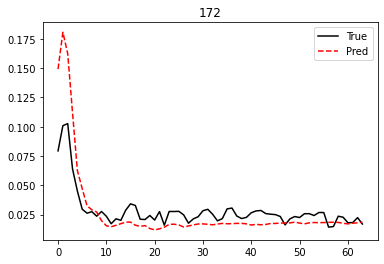

215


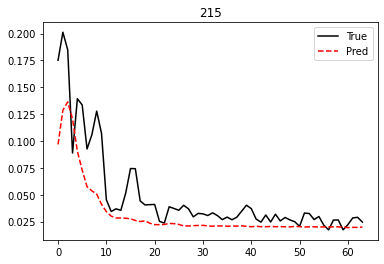

258


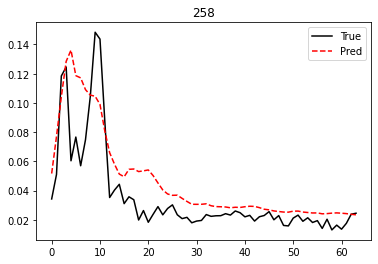

301


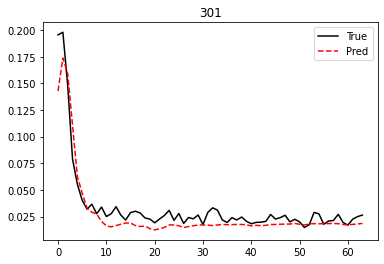

344


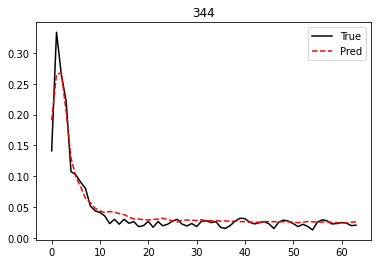

387


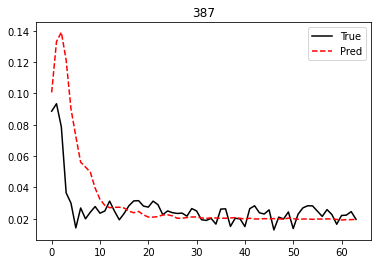

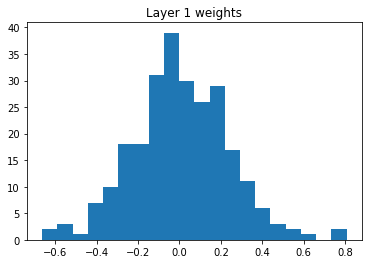

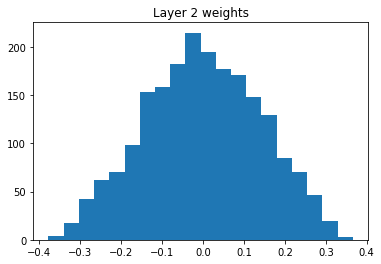

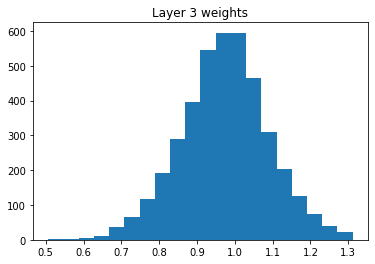

--------------------------------------------------
Leap 6
Epoch 1/60
13/13 [==============================] - 0s 10ms/step - loss: 8.3260e-04 - val_loss: 8.4432e-04
Epoch 2/60
13/13 [==============================] - 0s 8ms/step - loss: 8.4734e-04 - val_loss: 8.3839e-04
Epoch 3/60
13/13 [==============================] - 0s 6ms/step - loss: 8.4104e-04 - val_loss: 8.4071e-04
Epoch 4/60
13/13 [==============================] - 0s 9ms/step - loss: 8.8324e-04 - val_loss: 8.5903e-04
Epoch 5/60
13/13 [==============================] - 0s 9ms/step - loss: 8.1267e-04 - val_loss: 8.3667e-04
Epoch 6/60
13/13 [==============================] - 0s 8ms/step - loss: 8.5566e-04 - val_loss: 8.4253e-04
Epoch 7/60
13/13 [==============================] - 0s 9ms/step - loss: 8.4375e-04 - val_loss: 8.3406e-04
Epoch 8/60
13/13 [==============================] - 0s 7ms/step - loss: 8.5956e-04 - val_loss: 8.3870e-04
Epoch 9/60
13/13 [==============================] - 0s 9ms/step - loss: 8.4373e-04 - val_loss

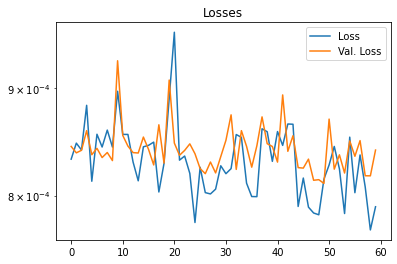

Loss median = 0.0008302797796204686
Loss width = 4.5659675379283726e-05
Val. Loss median = 0.0008386476256418973
Val. Loss width = 1.9333776435814798e-05
0


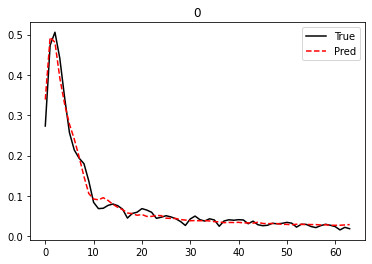

43


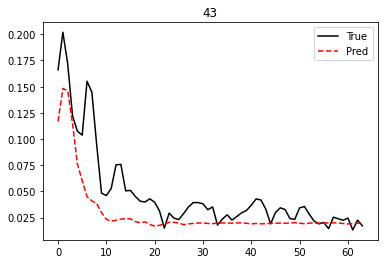

86


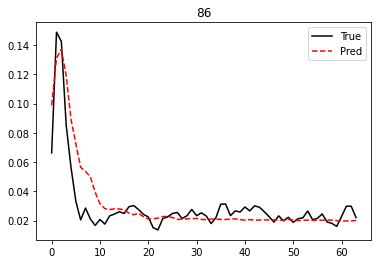

129


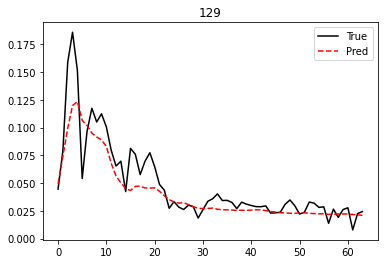

172


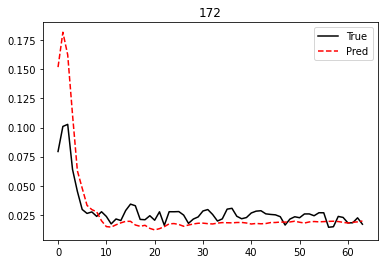

215


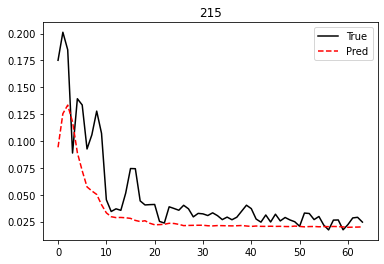

258


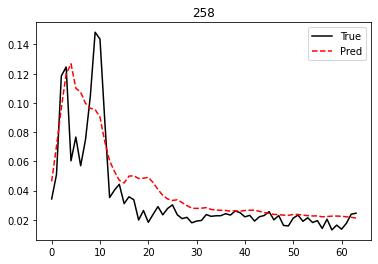

301


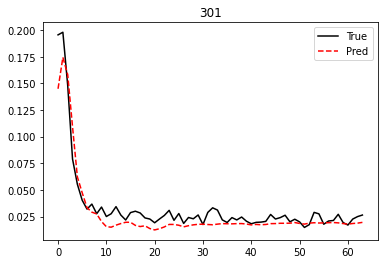

344


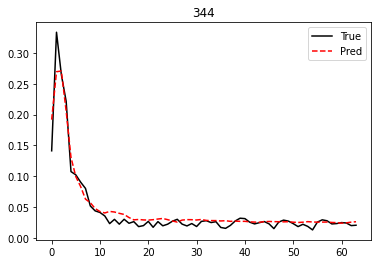

387


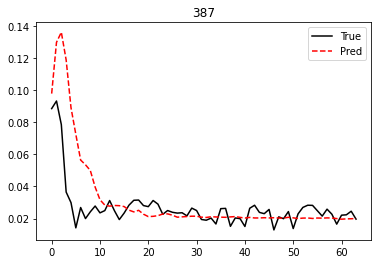

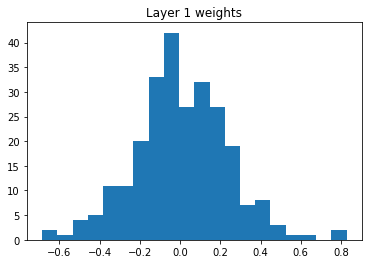

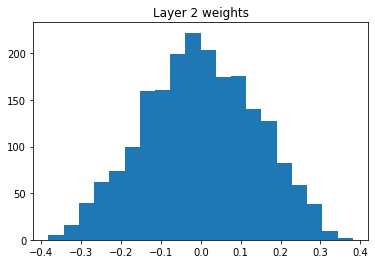

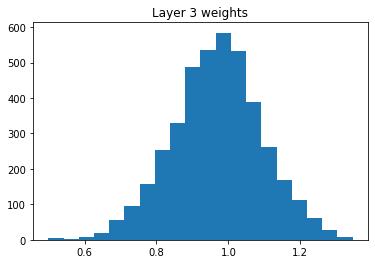

--------------------------------------------------
Leap 7
Epoch 1/60
13/13 [==============================] - 0s 15ms/step - loss: 7.9776e-04 - val_loss: 8.2211e-04
Epoch 2/60
13/13 [==============================] - 0s 10ms/step - loss: 7.8587e-04 - val_loss: 8.5258e-04
Epoch 3/60
13/13 [==============================] - 0s 14ms/step - loss: 7.5907e-04 - val_loss: 8.0761e-04
Epoch 4/60
13/13 [==============================] - 0s 11ms/step - loss: 7.8366e-04 - val_loss: 8.1380e-04
Epoch 5/60
13/13 [==============================] - 0s 9ms/step - loss: 7.8189e-04 - val_loss: 8.1491e-04
Epoch 6/60
13/13 [==============================] - 0s 12ms/step - loss: 7.7961e-04 - val_loss: 8.1708e-04
Epoch 7/60
13/13 [==============================] - 0s 10ms/step - loss: 8.1162e-04 - val_loss: 8.1835e-04
Epoch 8/60
13/13 [==============================] - 0s 11ms/step - loss: 8.6588e-04 - val_loss: 8.2644e-04
Epoch 9/60
13/13 [==============================] - 0s 8ms/step - loss: 8.0304e-04 - va

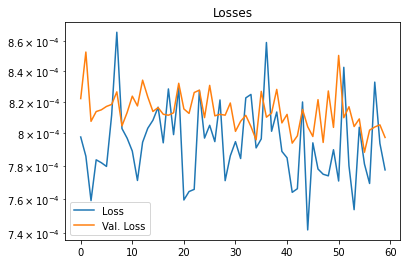

Loss median = 0.0007939494971651584
Loss width = 2.800066431518644e-05
Val. Loss median = 0.0008123521984089166
Val. Loss width = 1.457554753869772e-05
0


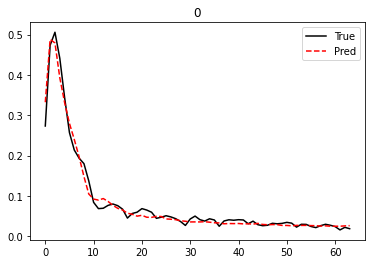

43


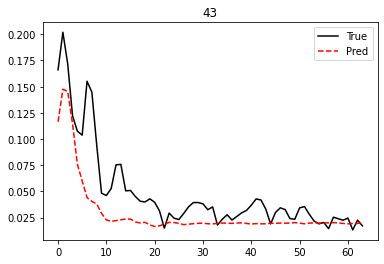

86


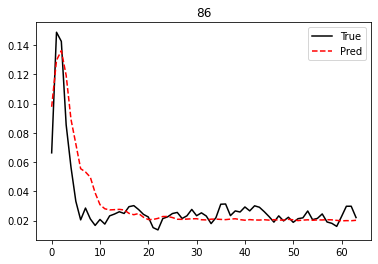

129


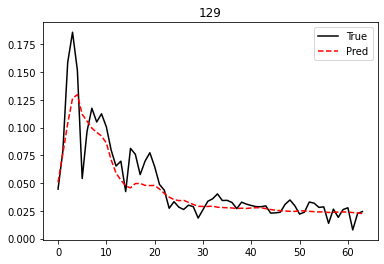

172


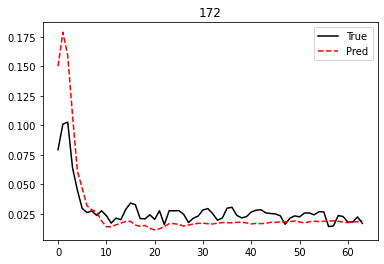

215


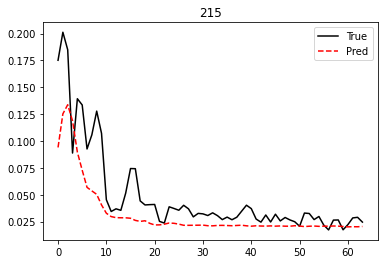

258


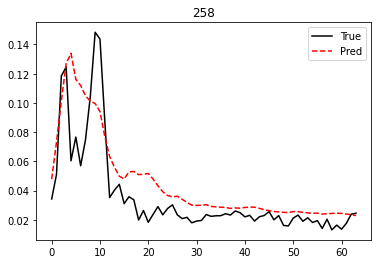

301


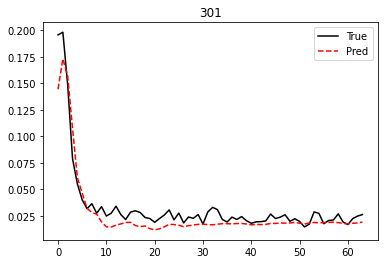

344


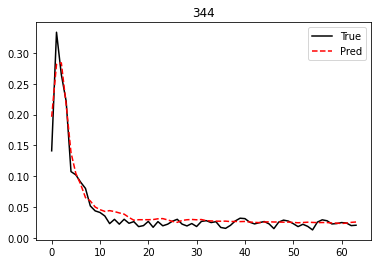

387


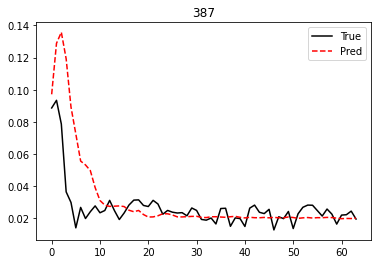

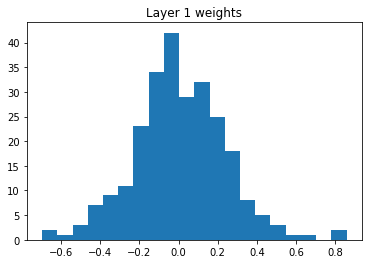

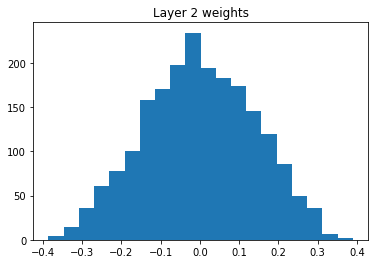

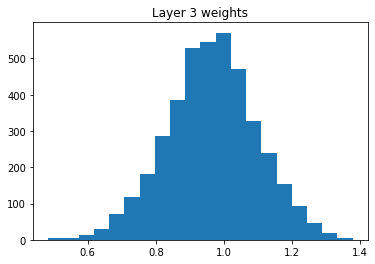

--------------------------------------------------
Leap 8
Epoch 1/60
13/13 [==============================] - 0s 12ms/step - loss: 7.7077e-04 - val_loss: 8.3371e-04
Epoch 2/60
13/13 [==============================] - 0s 8ms/step - loss: 7.6974e-04 - val_loss: 8.0099e-04
Epoch 3/60
13/13 [==============================] - 0s 8ms/step - loss: 7.9388e-04 - val_loss: 8.2002e-04
Epoch 4/60
13/13 [==============================] - 0s 8ms/step - loss: 7.8260e-04 - val_loss: 8.0381e-04
Epoch 5/60
13/13 [==============================] - 0s 8ms/step - loss: 8.6954e-04 - val_loss: 8.5904e-04
Epoch 6/60
13/13 [==============================] - 0s 8ms/step - loss: 8.0363e-04 - val_loss: 8.0407e-04
Epoch 7/60
13/13 [==============================] - 0s 9ms/step - loss: 7.5283e-04 - val_loss: 8.1814e-04
Epoch 8/60
13/13 [==============================] - 0s 7ms/step - loss: 8.0833e-04 - val_loss: 8.1181e-04
Epoch 9/60
13/13 [==============================] - 0s 7ms/step - loss: 7.4736e-04 - val_loss

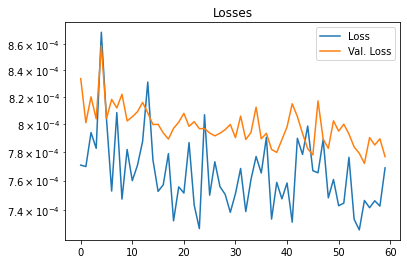

Loss median = 0.000760313356295228
Loss width = 3.127074160147458e-05
Val. Loss median = 0.0007968340651132166
Val. Loss width = 1.59356277436018e-05
0


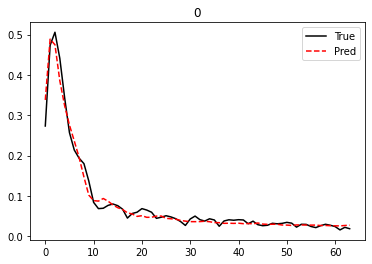

43


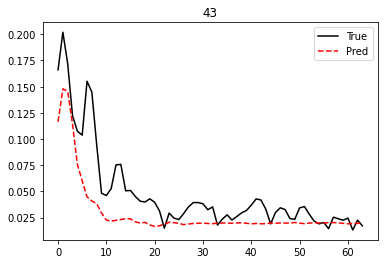

86


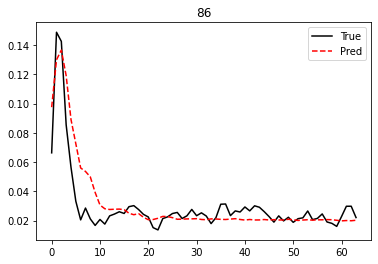

129


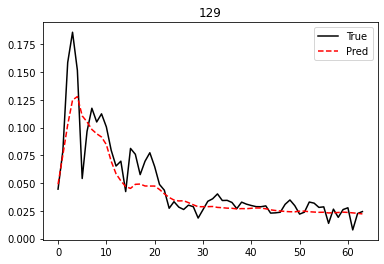

172


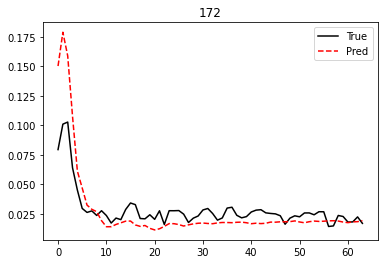

215


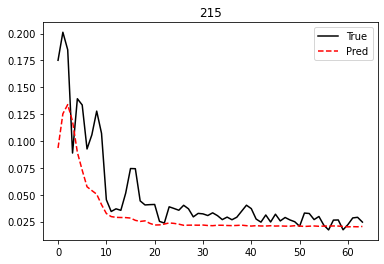

258


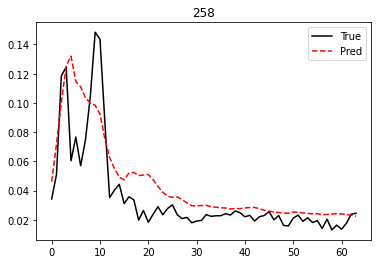

301


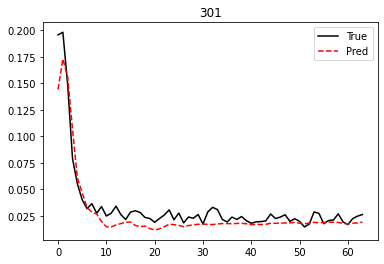

344


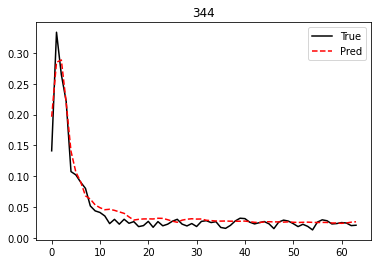

387


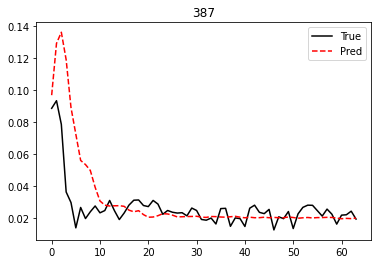

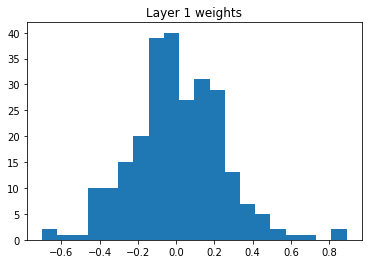

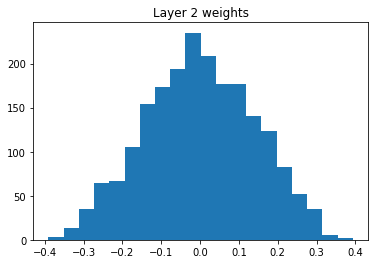

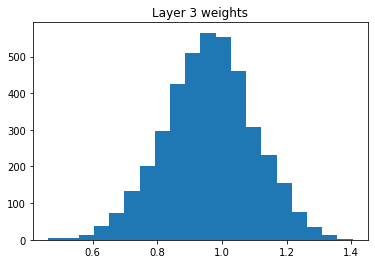

--------------------------------------------------
Leap 9
Epoch 1/60
13/13 [==============================] - 0s 9ms/step - loss: 7.7191e-04 - val_loss: 7.9419e-04
Epoch 2/60
13/13 [==============================] - 0s 7ms/step - loss: 7.1973e-04 - val_loss: 7.7642e-04
Epoch 3/60
13/13 [==============================] - 0s 8ms/step - loss: 7.7150e-04 - val_loss: 7.8894e-04
Epoch 4/60
13/13 [==============================] - 0s 8ms/step - loss: 7.6267e-04 - val_loss: 7.9528e-04
Epoch 5/60
13/13 [==============================] - 0s 7ms/step - loss: 8.1752e-04 - val_loss: 8.0443e-04
Epoch 6/60
13/13 [==============================] - 0s 7ms/step - loss: 7.8762e-04 - val_loss: 8.1433e-04
Epoch 7/60
13/13 [==============================] - 0s 8ms/step - loss: 7.3102e-04 - val_loss: 7.8705e-04
Epoch 8/60
13/13 [==============================] - 0s 7ms/step - loss: 7.5595e-04 - val_loss: 7.8366e-04
Epoch 9/60
13/13 [==============================] - 0s 7ms/step - loss: 7.8810e-04 - val_loss:

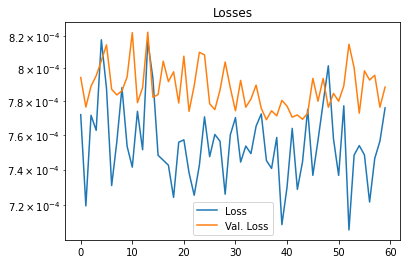

Loss median = 0.0007536553603131324
Loss width = 2.8000897145830095e-05
Val. Loss median = 0.0007867869280744344
Val. Loss width = 1.8382095731794834e-05
0


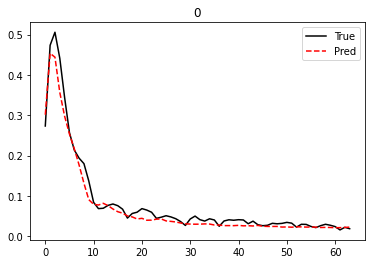

43


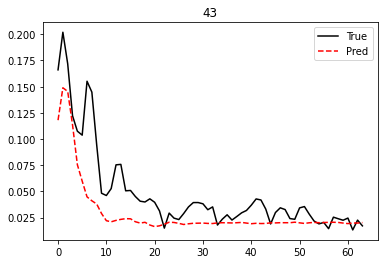

86


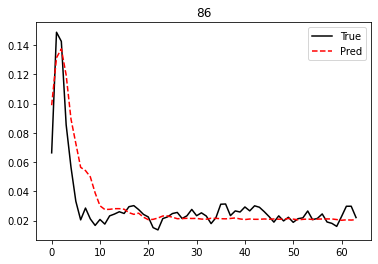

129


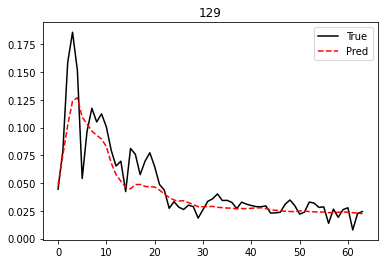

172


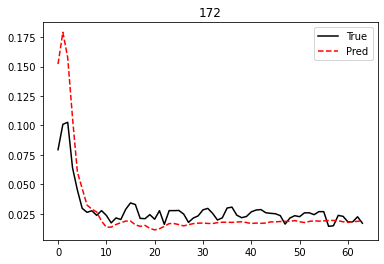

215


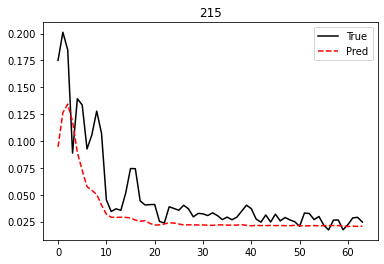

258


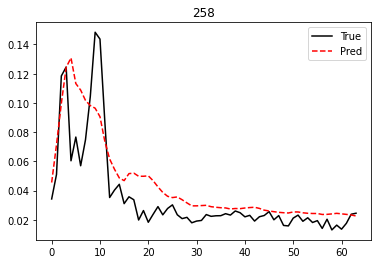

301


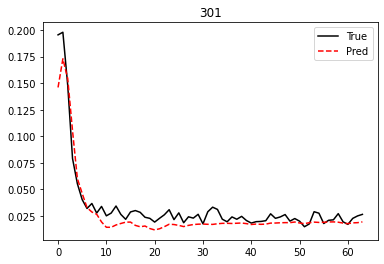

344


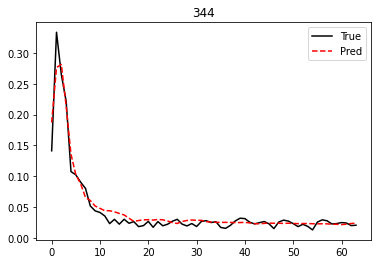

387


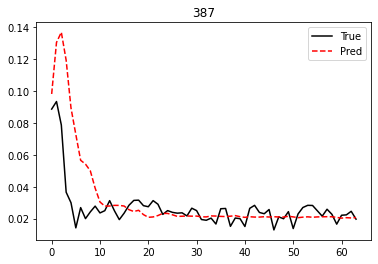

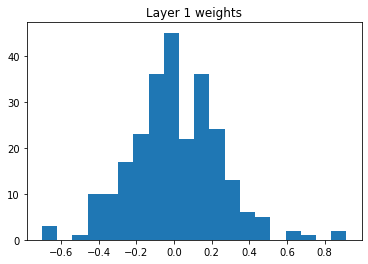

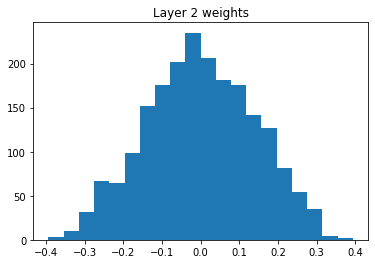

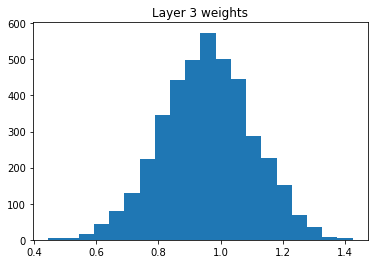

--------------------------------------------------
Leap 10
Epoch 1/60
13/13 [==============================] - 0s 10ms/step - loss: 7.7385e-04 - val_loss: 8.0518e-04
Epoch 2/60
13/13 [==============================] - 0s 9ms/step - loss: 7.2395e-04 - val_loss: 7.7575e-04
Epoch 3/60
13/13 [==============================] - 0s 8ms/step - loss: 7.9045e-04 - val_loss: 7.7612e-04
Epoch 4/60
13/13 [==============================] - 0s 8ms/step - loss: 7.6755e-04 - val_loss: 7.8032e-04
Epoch 5/60
13/13 [==============================] - 0s 9ms/step - loss: 7.5656e-04 - val_loss: 7.6599e-04
Epoch 6/60
13/13 [==============================] - 0s 8ms/step - loss: 7.4331e-04 - val_loss: 7.7582e-04
Epoch 7/60
13/13 [==============================] - 0s 8ms/step - loss: 8.0119e-04 - val_loss: 7.8649e-04
Epoch 8/60
13/13 [==============================] - 0s 8ms/step - loss: 7.1591e-04 - val_loss: 7.7219e-04
Epoch 9/60
13/13 [==============================] - 0s 8ms/step - loss: 7.4694e-04 - val_los

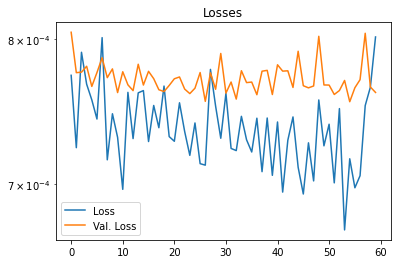

Loss median = 0.0007331125088967383
Loss width = 3.483220643829554e-05
Val. Loss median = 0.0007688680780120194
Val. Loss width = 1.2645410606637597e-05
0


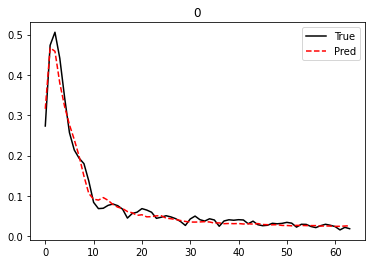

43


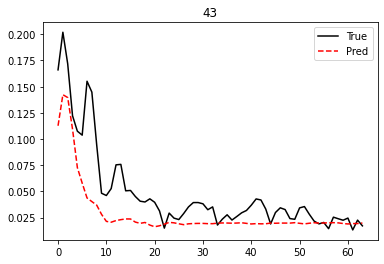

86


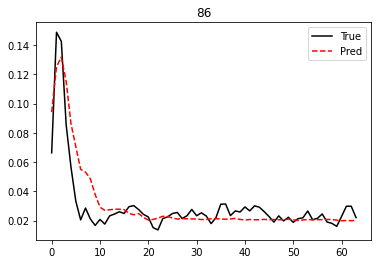

129


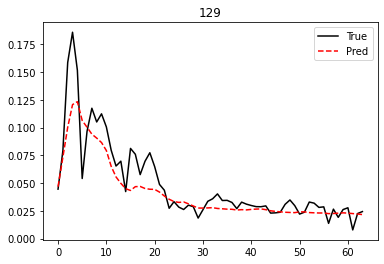

172


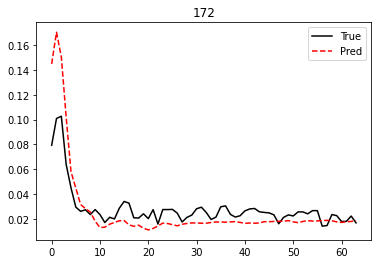

215


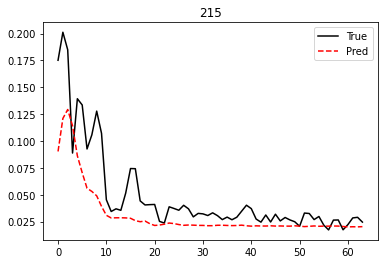

258


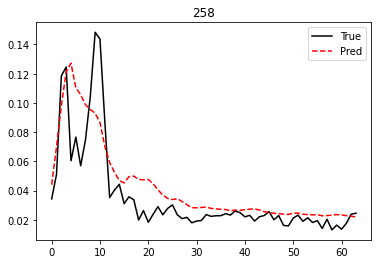

301


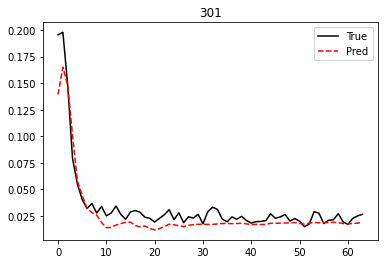

344


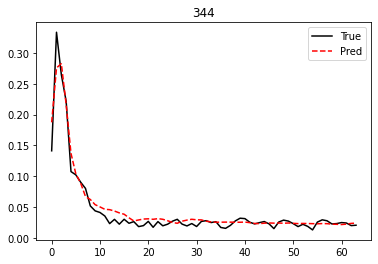

387


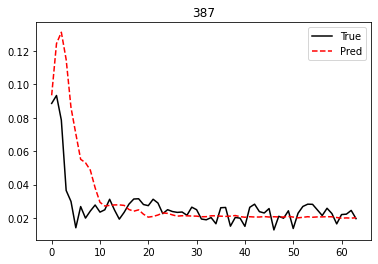

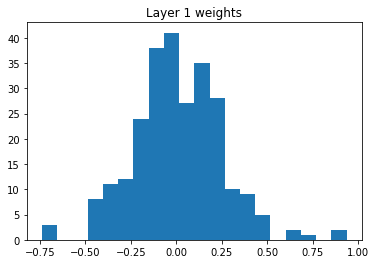

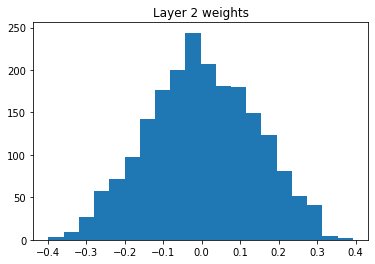

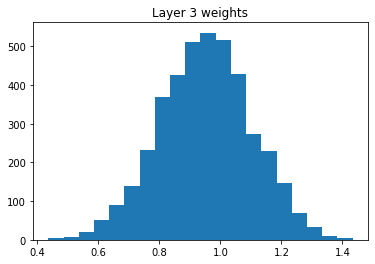

--------------------------------------------------
Leap 11
Epoch 1/60
13/13 [==============================] - 0s 13ms/step - loss: 7.3823e-04 - val_loss: 7.6302e-04
Epoch 2/60
13/13 [==============================] - 0s 9ms/step - loss: 6.9202e-04 - val_loss: 7.7541e-04
Epoch 3/60
13/13 [==============================] - 0s 7ms/step - loss: 7.3628e-04 - val_loss: 7.6254e-04
Epoch 4/60
13/13 [==============================] - 0s 9ms/step - loss: 7.1286e-04 - val_loss: 7.6710e-04
Epoch 5/60
13/13 [==============================] - 0s 8ms/step - loss: 7.3999e-04 - val_loss: 7.5387e-04
Epoch 6/60
13/13 [==============================] - 0s 8ms/step - loss: 7.1717e-04 - val_loss: 7.5249e-04
Epoch 7/60
13/13 [==============================] - 0s 9ms/step - loss: 7.2091e-04 - val_loss: 7.5360e-04
Epoch 8/60
13/13 [==============================] - 0s 8ms/step - loss: 7.1389e-04 - val_loss: 7.5498e-04
Epoch 9/60
13/13 [==============================] - 0s 8ms/step - loss: 7.0631e-04 - val_los

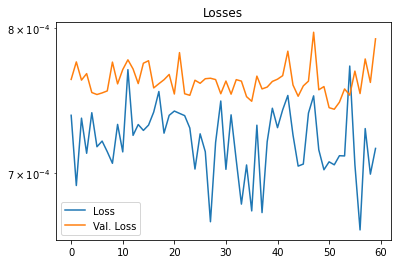

Loss median = 0.0007228190952446312
Loss width = 3.20184335578233e-05
Val. Loss median = 0.0007612470944877714
Val. Loss width = 1.207191962748766e-05
0


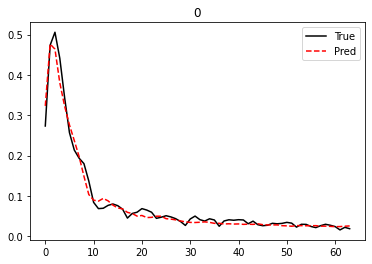

43


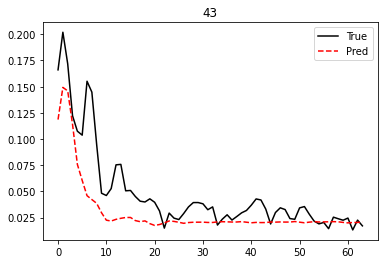

86


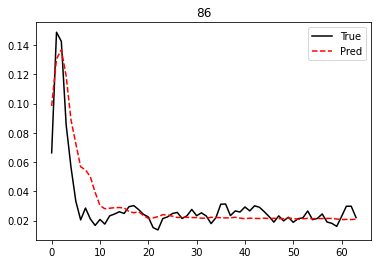

129


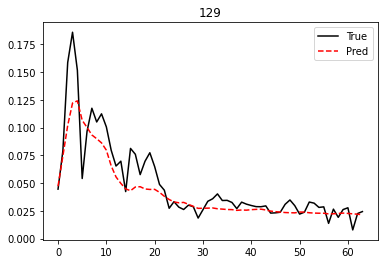

172


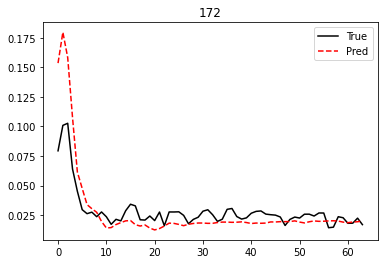

215


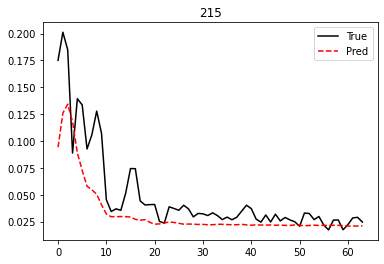

258


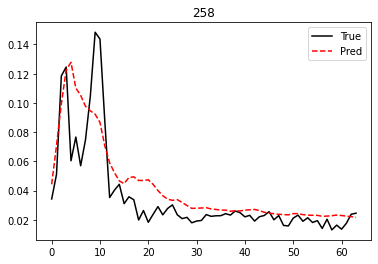

301


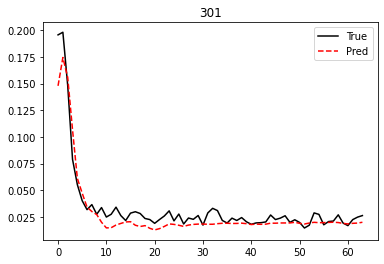

344


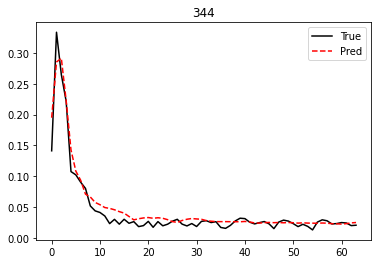

387


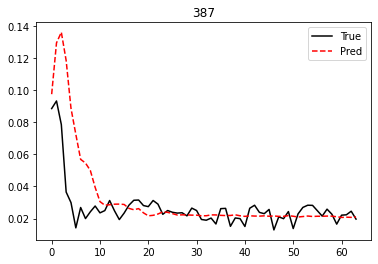

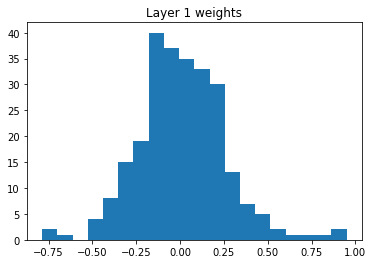

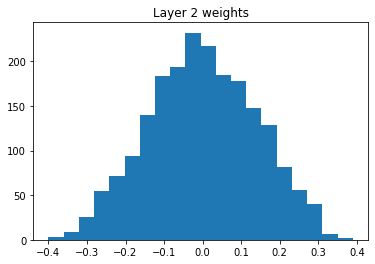

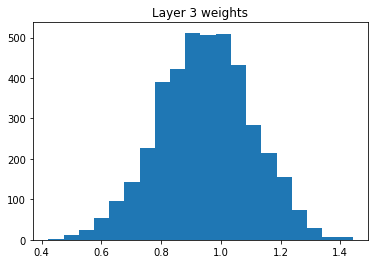

--------------------------------------------------
Leap 12
Epoch 1/60
13/13 [==============================] - 0s 12ms/step - loss: 7.1701e-04 - val_loss: 7.7027e-04
Epoch 2/60
13/13 [==============================] - 0s 9ms/step - loss: 7.2748e-04 - val_loss: 7.5256e-04
Epoch 3/60
13/13 [==============================] - 0s 9ms/step - loss: 7.0426e-04 - val_loss: 7.4434e-04
Epoch 4/60
13/13 [==============================] - 0s 8ms/step - loss: 7.1430e-04 - val_loss: 7.4618e-04
Epoch 5/60
13/13 [==============================] - 0s 9ms/step - loss: 6.8434e-04 - val_loss: 7.4746e-04
Epoch 6/60
13/13 [==============================] - 0s 10ms/step - loss: 7.5367e-04 - val_loss: 7.4924e-04
Epoch 7/60
13/13 [==============================] - 0s 8ms/step - loss: 7.1010e-04 - val_loss: 7.5749e-04
Epoch 8/60
13/13 [==============================] - 0s 8ms/step - loss: 6.8824e-04 - val_loss: 7.5857e-04
Epoch 9/60
13/13 [==============================] - 0s 8ms/step - loss: 6.8826e-04 - val_lo

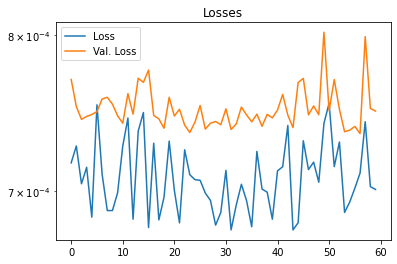

Loss median = 0.0007047279505059123
Loss width = 3.369055048096925e-05
Val. Loss median = 0.0007475038291886449
Val. Loss width = 1.1031734175048769e-05
0


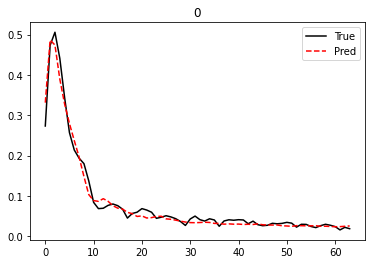

43


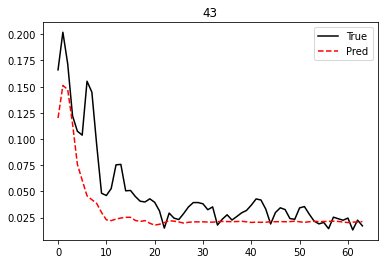

86


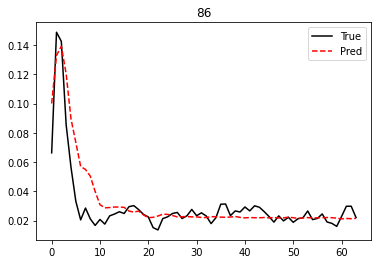

129


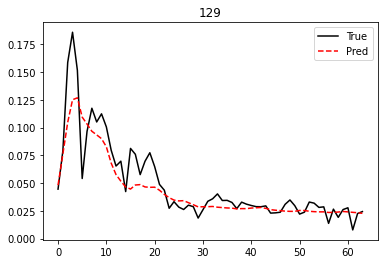

172


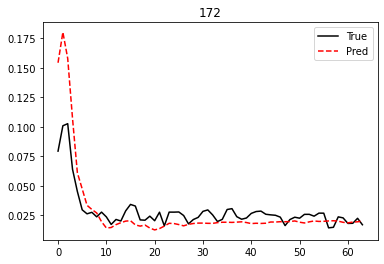

215


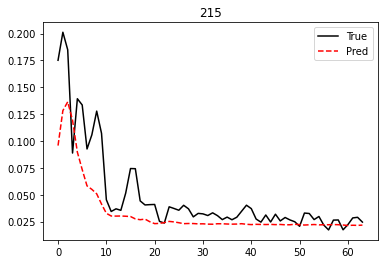

258


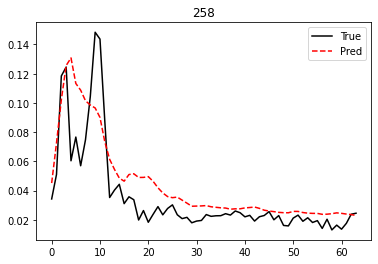

301


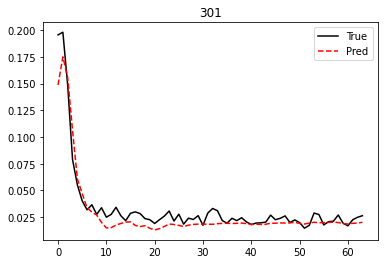

344


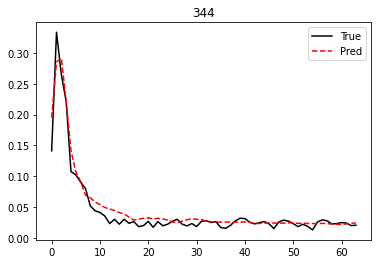

387


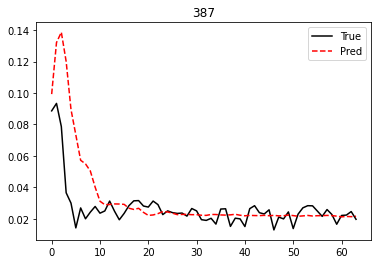

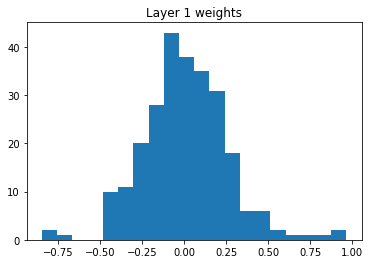

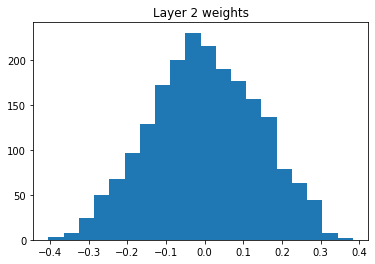

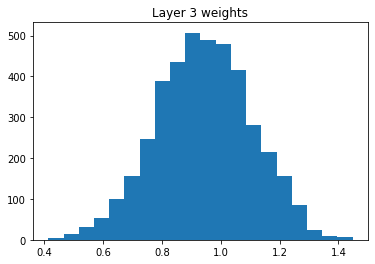

--------------------------------------------------
Leap 13
Epoch 1/60
13/13 [==============================] - 0s 14ms/step - loss: 7.0856e-04 - val_loss: 7.5054e-04
Epoch 2/60
13/13 [==============================] - 0s 8ms/step - loss: 6.8509e-04 - val_loss: 7.3961e-04
Epoch 3/60
13/13 [==============================] - 0s 9ms/step - loss: 6.8339e-04 - val_loss: 7.3353e-04
Epoch 4/60
13/13 [==============================] - 0s 7ms/step - loss: 7.2432e-04 - val_loss: 7.3733e-04
Epoch 5/60
13/13 [==============================] - 0s 7ms/step - loss: 7.0405e-04 - val_loss: 7.3379e-04
Epoch 6/60
13/13 [==============================] - 0s 9ms/step - loss: 7.5208e-04 - val_loss: 7.5515e-04
Epoch 7/60
13/13 [==============================] - 0s 8ms/step - loss: 7.5020e-04 - val_loss: 7.3596e-04
Epoch 8/60
13/13 [==============================] - 0s 8ms/step - loss: 7.3281e-04 - val_loss: 7.4453e-04
Epoch 9/60
13/13 [==============================] - 0s 8ms/step - loss: 6.7506e-04 - val_los

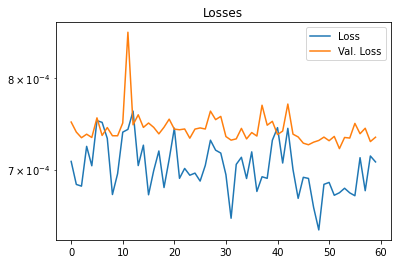

Loss median = 0.0006996433658059686
Loss width = 3.4086246159859e-05
Val. Loss median = 0.0007393581618089229
Val. Loss width = 1.3199591194279492e-05
0


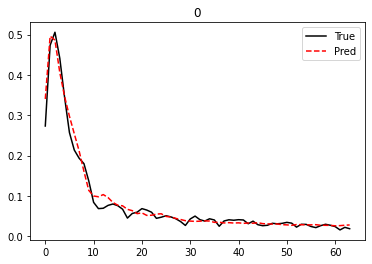

43


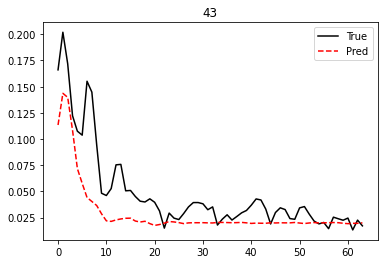

86


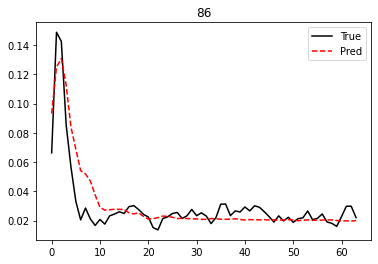

129


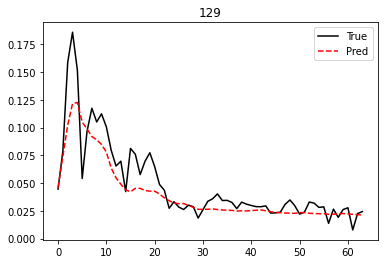

172


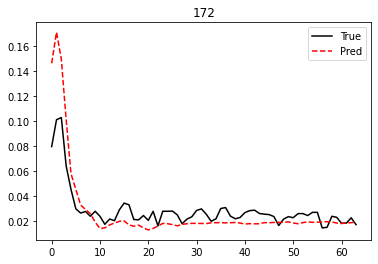

215


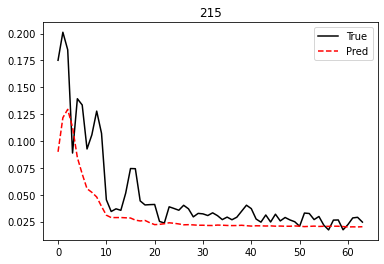

258


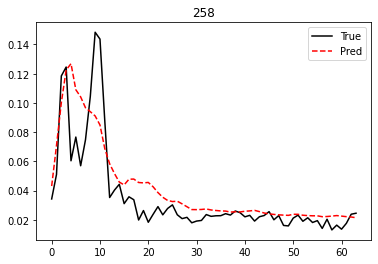

301


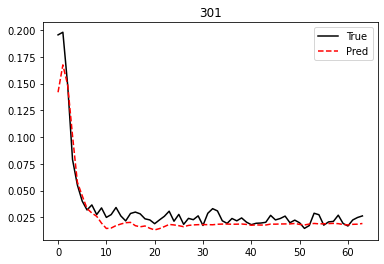

344


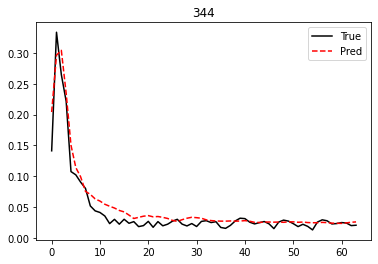

387


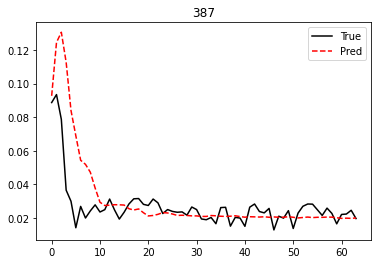

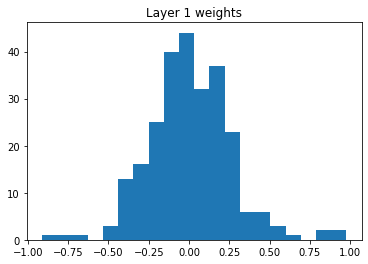

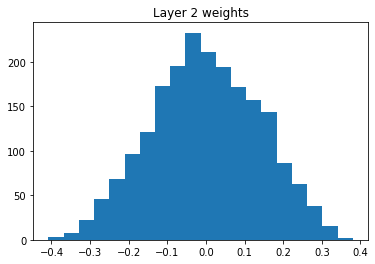

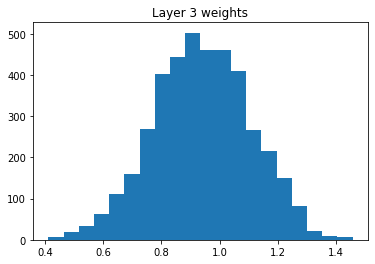

--------------------------------------------------
Leap 14
Epoch 1/60
13/13 [==============================] - 0s 10ms/step - loss: 7.2118e-04 - val_loss: 7.2568e-04
Epoch 2/60
13/13 [==============================] - 0s 7ms/step - loss: 7.2364e-04 - val_loss: 7.4200e-04
Epoch 3/60
13/13 [==============================] - 0s 9ms/step - loss: 6.8119e-04 - val_loss: 7.3396e-04
Epoch 4/60
13/13 [==============================] - 0s 10ms/step - loss: 6.8545e-04 - val_loss: 7.3569e-04
Epoch 5/60
13/13 [==============================] - 0s 9ms/step - loss: 6.7843e-04 - val_loss: 7.3336e-04
Epoch 6/60
13/13 [==============================] - 0s 8ms/step - loss: 6.7887e-04 - val_loss: 7.3311e-04
Epoch 7/60
13/13 [==============================] - 0s 9ms/step - loss: 6.7148e-04 - val_loss: 7.3666e-04
Epoch 8/60
13/13 [==============================] - 0s 8ms/step - loss: 6.7834e-04 - val_loss: 7.2524e-04
Epoch 9/60
13/13 [==============================] - 0s 8ms/step - loss: 7.0089e-04 - val_lo

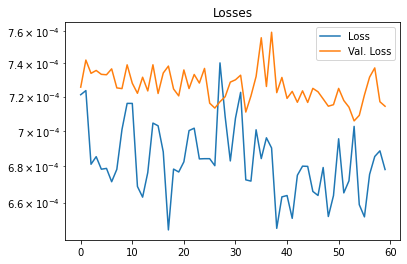

Loss median = 0.0006802539282944053
Loss width = 2.541863068472594e-05
Val. Loss median = 0.0007248969632200897
Val. Loss width = 1.4211531379260123e-05
0


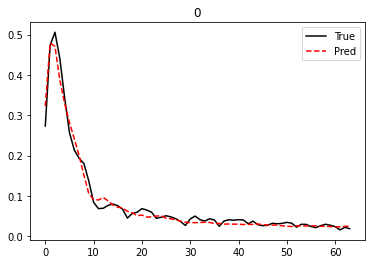

43


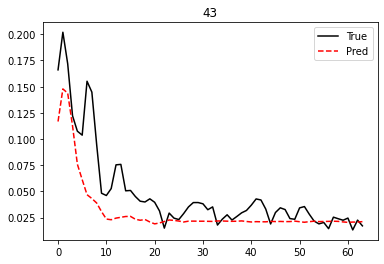

86


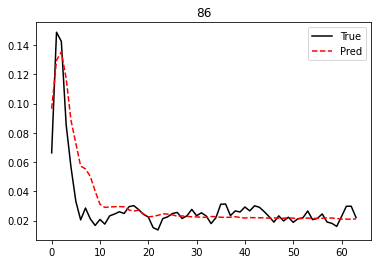

129


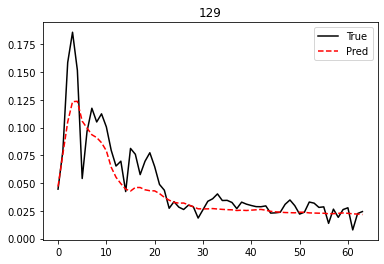

172


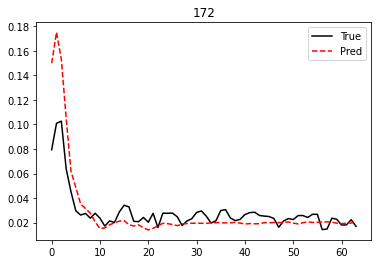

215


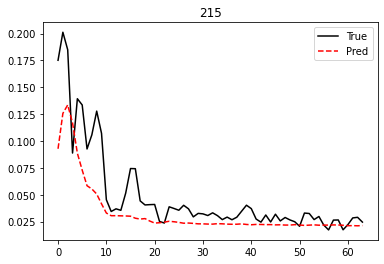

258


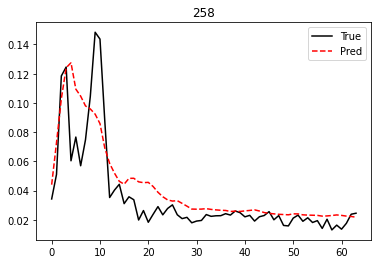

301


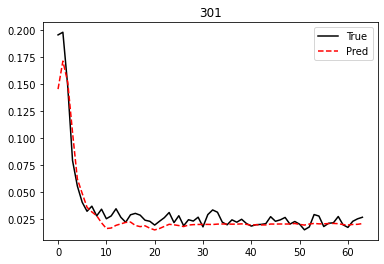

344


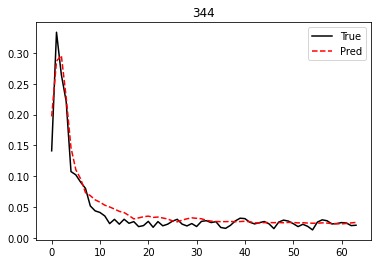

387


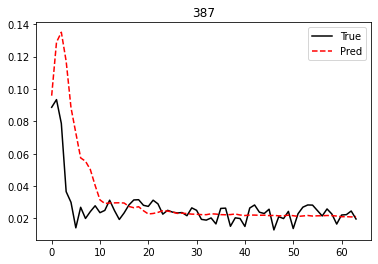

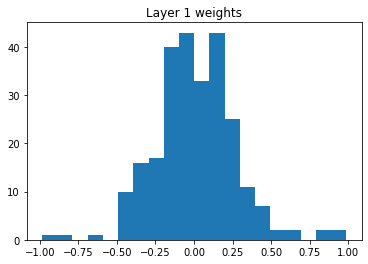

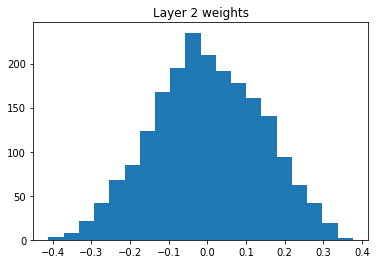

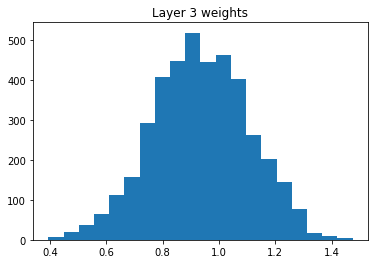

--------------------------------------------------
Leap 15
Epoch 1/60
13/13 [==============================] - 0s 15ms/step - loss: 6.9369e-04 - val_loss: 7.1537e-04
Epoch 2/60
13/13 [==============================] - 0s 9ms/step - loss: 6.9086e-04 - val_loss: 7.3045e-04
Epoch 3/60
13/13 [==============================] - 0s 8ms/step - loss: 6.7680e-04 - val_loss: 7.0930e-04
Epoch 4/60
13/13 [==============================] - 0s 7ms/step - loss: 6.9287e-04 - val_loss: 7.2246e-04
Epoch 5/60
13/13 [==============================] - 0s 9ms/step - loss: 6.6945e-04 - val_loss: 7.2978e-04
Epoch 6/60
13/13 [==============================] - 0s 9ms/step - loss: 6.8305e-04 - val_loss: 7.2694e-04
Epoch 7/60
13/13 [==============================] - 0s 9ms/step - loss: 6.8680e-04 - val_loss: 7.4517e-04
Epoch 8/60
13/13 [==============================] - 0s 9ms/step - loss: 6.8649e-04 - val_loss: 7.1406e-04
Epoch 9/60
13/13 [==============================] - 0s 9ms/step - loss: 6.6615e-04 - val_los

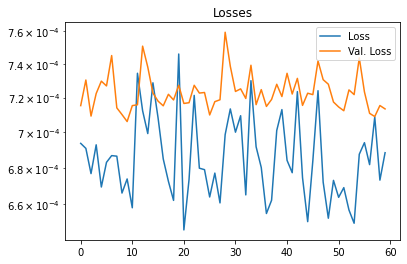

Loss median = 0.0006824111915193498
Loss width = 3.008906787727028e-05
Val. Loss median = 0.0007219159742817283
Val. Loss width = 1.201096165459603e-05
0


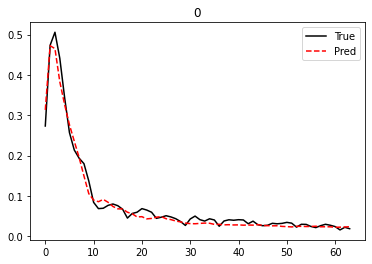

43


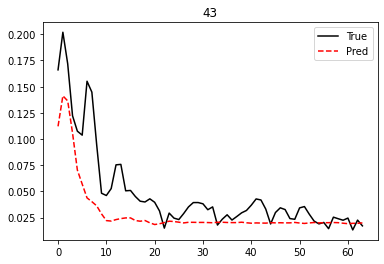

86


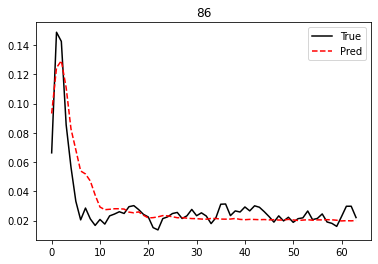

129


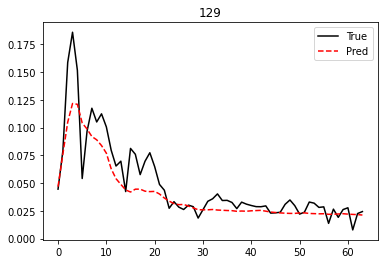

172


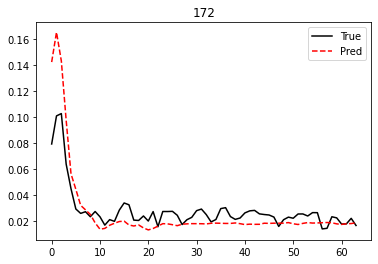

215


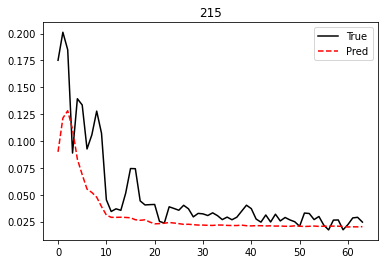

258


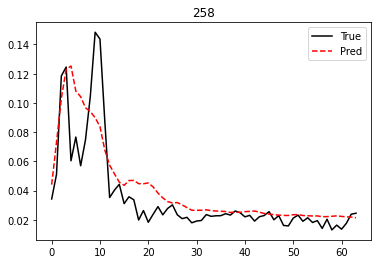

301


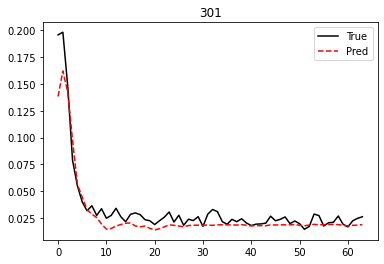

344


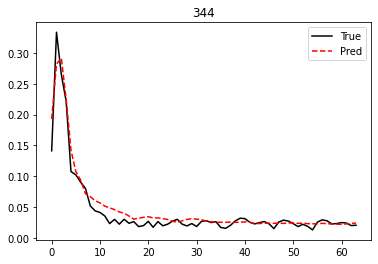

387


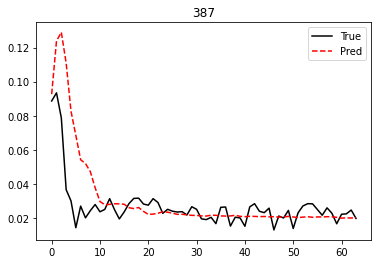

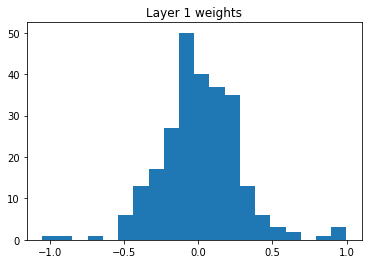

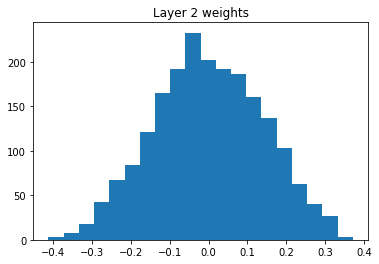

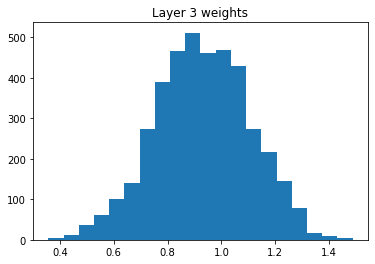

--------------------------------------------------
Leap 16
Epoch 1/60
13/13 [==============================] - 0s 13ms/step - loss: 6.6572e-04 - val_loss: 7.0721e-04
Epoch 2/60
13/13 [==============================] - 0s 8ms/step - loss: 6.7475e-04 - val_loss: 7.0532e-04
Epoch 3/60
13/13 [==============================] - 0s 9ms/step - loss: 6.3876e-04 - val_loss: 7.1307e-04
Epoch 4/60
13/13 [==============================] - 0s 9ms/step - loss: 6.8544e-04 - val_loss: 7.1110e-04
Epoch 5/60
13/13 [==============================] - 0s 9ms/step - loss: 6.7505e-04 - val_loss: 6.9952e-04
Epoch 6/60
13/13 [==============================] - 0s 9ms/step - loss: 6.6559e-04 - val_loss: 7.0228e-04
Epoch 7/60
13/13 [==============================] - 0s 9ms/step - loss: 6.4362e-04 - val_loss: 7.0699e-04
Epoch 8/60
13/13 [==============================] - 0s 8ms/step - loss: 6.4502e-04 - val_loss: 7.0634e-04
Epoch 9/60
13/13 [==============================] - 0s 8ms/step - loss: 6.5059e-04 - val_los

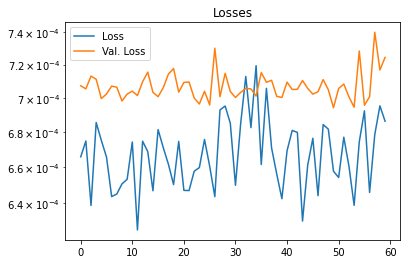

Loss median = 0.000668929103994742
Loss width = 3.048656799364835e-05
Val. Loss median = 0.0007051939319353551
Val. Loss width = 8.839298970997334e-06
0


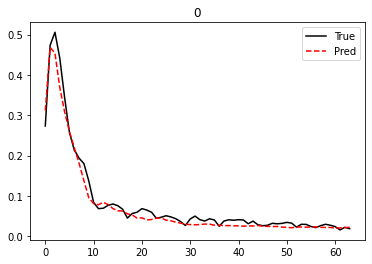

43


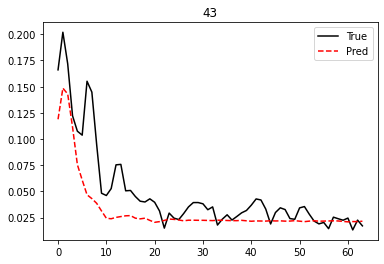

86


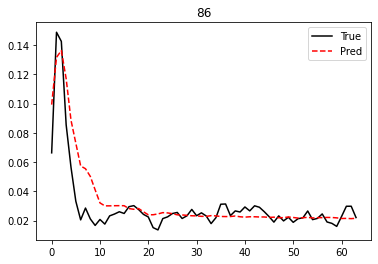

129


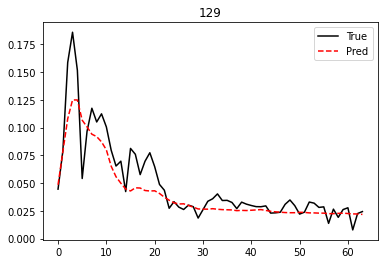

172


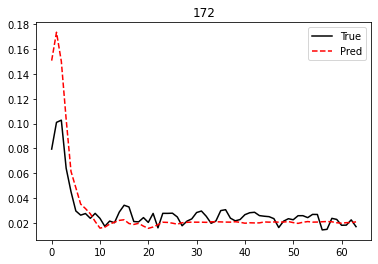

215


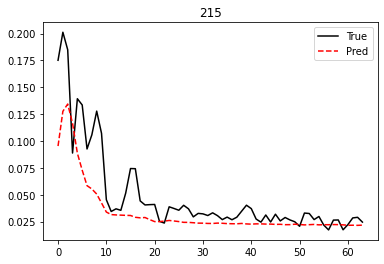

258


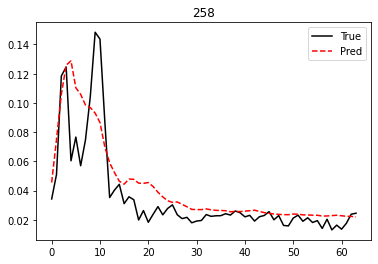

301


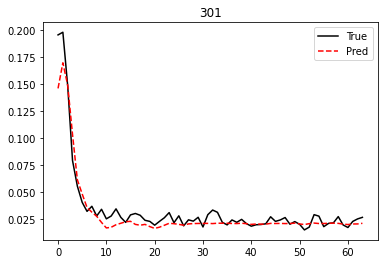

344


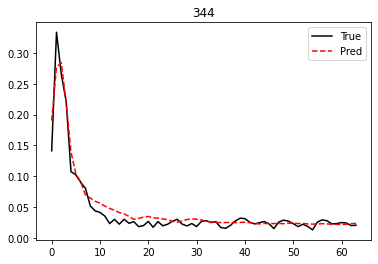

387


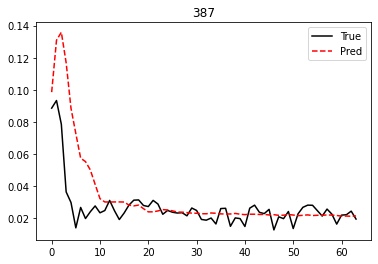

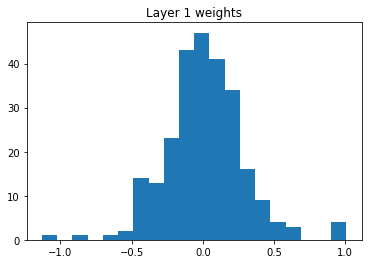

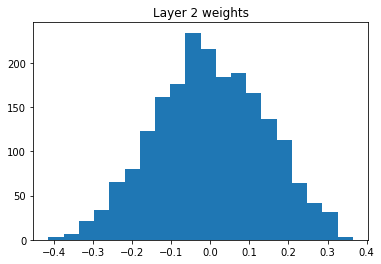

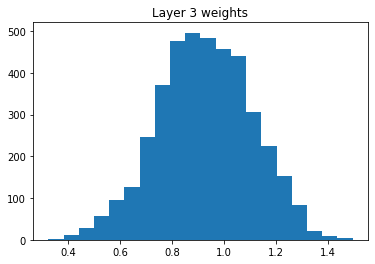

--------------------------------------------------
Leap 17
Epoch 1/60
13/13 [==============================] - 0s 12ms/step - loss: 7.0950e-04 - val_loss: 6.9437e-04
Epoch 2/60
13/13 [==============================] - 0s 9ms/step - loss: 6.5174e-04 - val_loss: 6.9390e-04
Epoch 3/60
13/13 [==============================] - 0s 9ms/step - loss: 6.9681e-04 - val_loss: 7.1182e-04
Epoch 4/60
13/13 [==============================] - 0s 9ms/step - loss: 6.7059e-04 - val_loss: 7.0667e-04
Epoch 5/60
13/13 [==============================] - 0s 7ms/step - loss: 6.7545e-04 - val_loss: 7.0586e-04
Epoch 6/60
13/13 [==============================] - 0s 7ms/step - loss: 6.6779e-04 - val_loss: 7.1604e-04
Epoch 7/60
13/13 [==============================] - 0s 8ms/step - loss: 6.6613e-04 - val_loss: 7.0894e-04
Epoch 8/60
13/13 [==============================] - 0s 8ms/step - loss: 6.7208e-04 - val_loss: 6.9687e-04
Epoch 9/60
13/13 [==============================] - 0s 9ms/step - loss: 6.8446e-04 - val_los

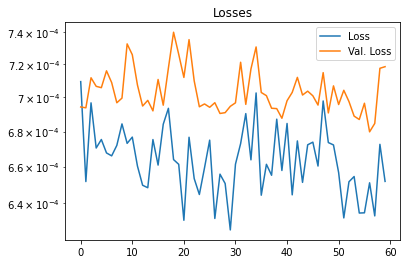

Loss median = 0.0006613948789890856
Loss width = 2.3200685973279178e-05
Val. Loss median = 0.0007003177597653121
Val. Loss width = 1.717291888780892e-05
0


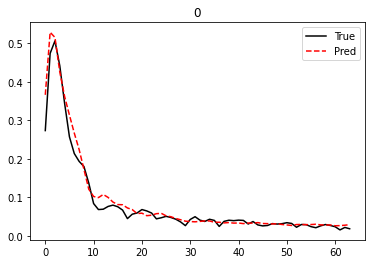

43


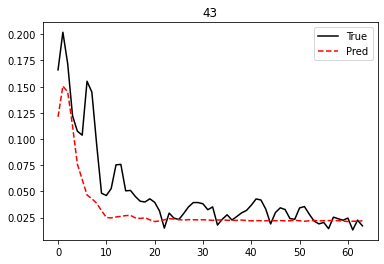

86


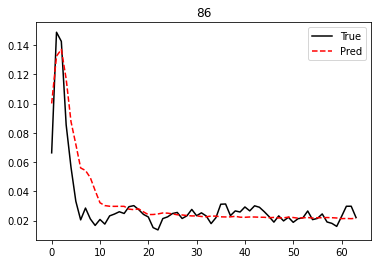

129


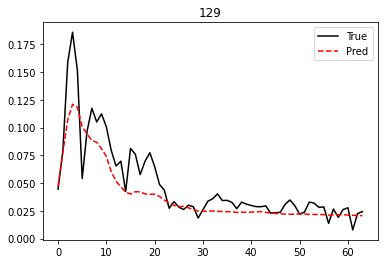

172


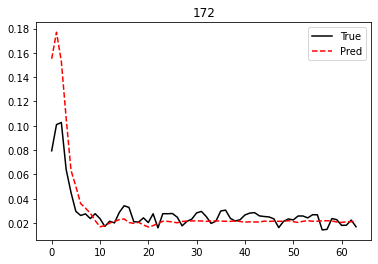

215


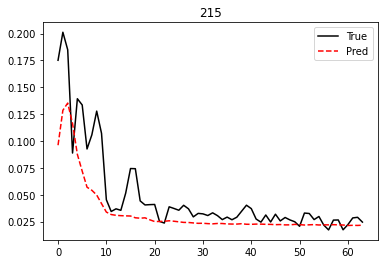

258


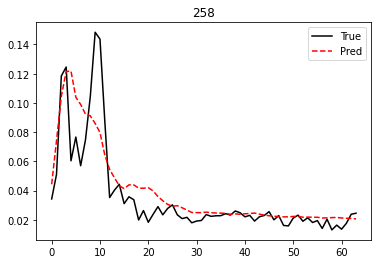

301


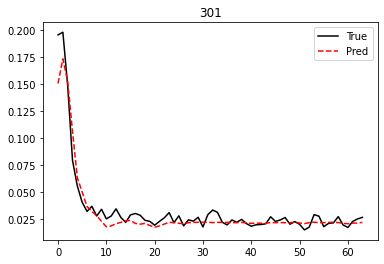

344


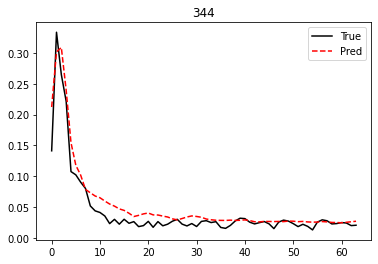

387


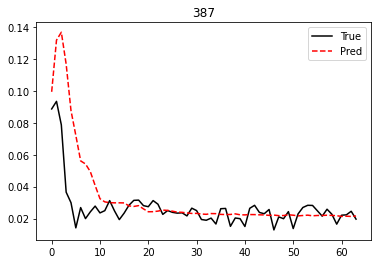

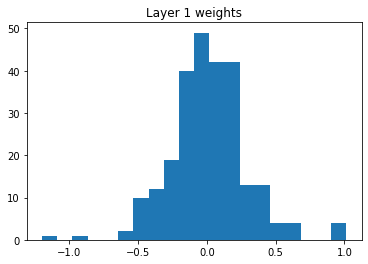

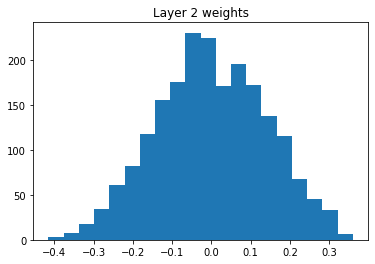

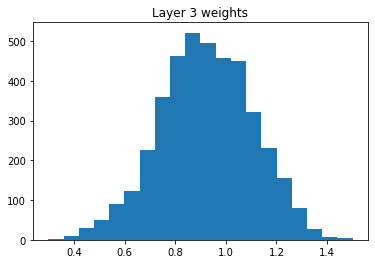

--------------------------------------------------
Leap 18
Epoch 1/60
13/13 [==============================] - 0s 13ms/step - loss: 6.4578e-04 - val_loss: 7.0000e-04
Epoch 2/60
13/13 [==============================] - 0s 7ms/step - loss: 6.6096e-04 - val_loss: 7.1297e-04
Epoch 3/60
13/13 [==============================] - 0s 9ms/step - loss: 6.7628e-04 - val_loss: 6.9348e-04
Epoch 4/60
13/13 [==============================] - 0s 9ms/step - loss: 6.4726e-04 - val_loss: 7.0012e-04
Epoch 5/60
13/13 [==============================] - 0s 9ms/step - loss: 6.7095e-04 - val_loss: 6.8580e-04
Epoch 6/60
13/13 [==============================] - 0s 8ms/step - loss: 6.6458e-04 - val_loss: 6.8803e-04
Epoch 7/60
13/13 [==============================] - 0s 8ms/step - loss: 6.4272e-04 - val_loss: 7.0389e-04
Epoch 8/60
13/13 [==============================] - 0s 9ms/step - loss: 6.6736e-04 - val_loss: 7.0998e-04
Epoch 9/60
13/13 [==============================] - 0s 9ms/step - loss: 6.4644e-04 - val_los

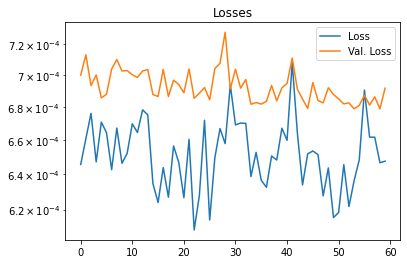

Loss median = 0.000651132664643228
Loss width = 2.7062444132752717e-05
Val. Loss median = 0.0006916392594575882
Val. Loss width = 1.5198034816421568e-05
0


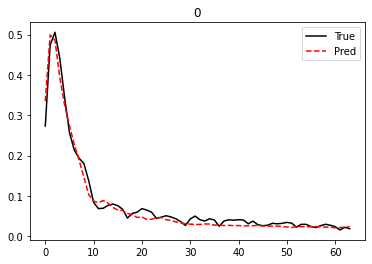

43


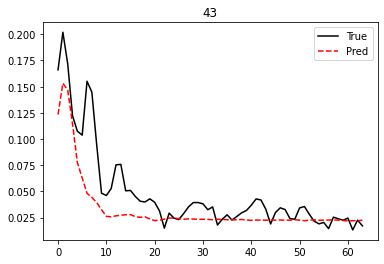

86


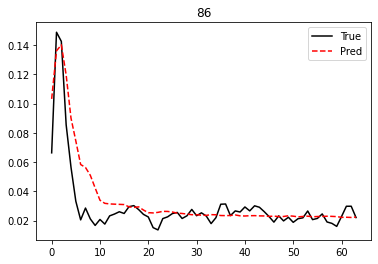

129


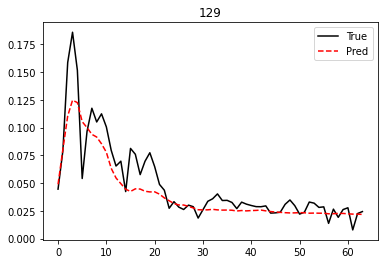

172


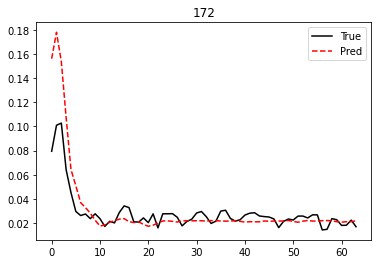

215


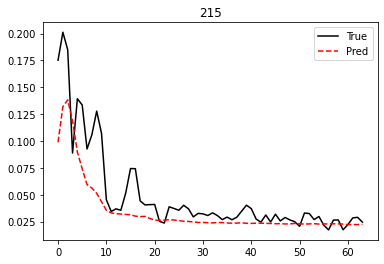

258


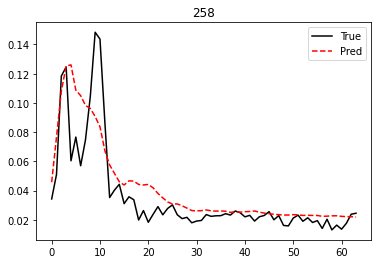

301


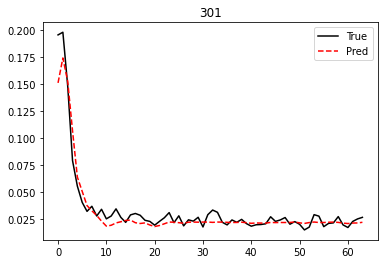

344


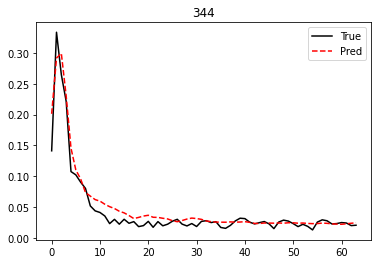

387


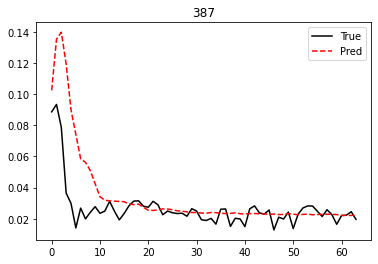

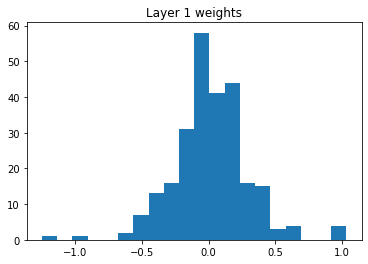

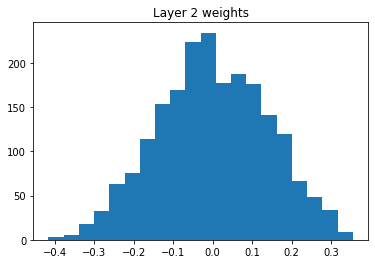

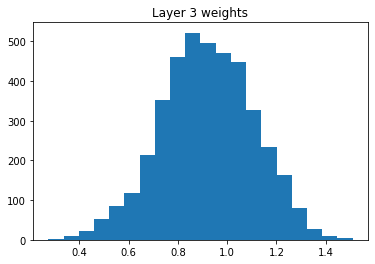

--------------------------------------------------
Leap 19
Epoch 1/60
13/13 [==============================] - 0s 12ms/step - loss: 6.3072e-04 - val_loss: 6.9458e-04
Epoch 2/60
13/13 [==============================] - 0s 9ms/step - loss: 6.7077e-04 - val_loss: 6.8514e-04
Epoch 3/60
13/13 [==============================] - 0s 9ms/step - loss: 6.6166e-04 - val_loss: 6.9118e-04
Epoch 4/60
13/13 [==============================] - 0s 9ms/step - loss: 6.4760e-04 - val_loss: 6.7804e-04
Epoch 5/60
13/13 [==============================] - 0s 8ms/step - loss: 6.6518e-04 - val_loss: 6.9195e-04
Epoch 6/60
13/13 [==============================] - 0s 9ms/step - loss: 6.0908e-04 - val_loss: 6.9157e-04
Epoch 7/60
13/13 [==============================] - 0s 8ms/step - loss: 6.4564e-04 - val_loss: 6.8332e-04
Epoch 8/60
13/13 [==============================] - 0s 10ms/step - loss: 6.5053e-04 - val_loss: 6.8426e-04
Epoch 9/60
13/13 [==============================] - 0s 9ms/step - loss: 6.2789e-04 - val_lo

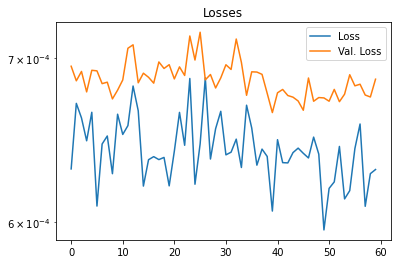

Loss median = 0.0006405792373698205
Loss width = 2.1012703655287623e-05
Val. Loss median = 0.0006857102271169424
Val. Loss width = 1.4675577403977513e-05
0


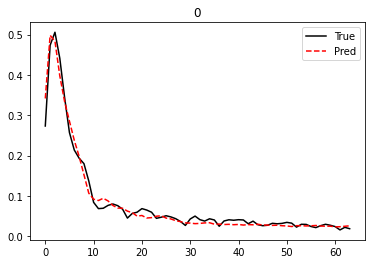

43


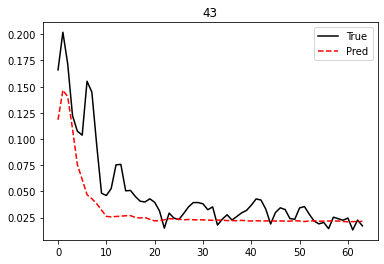

86


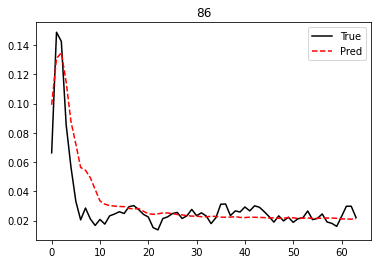

129


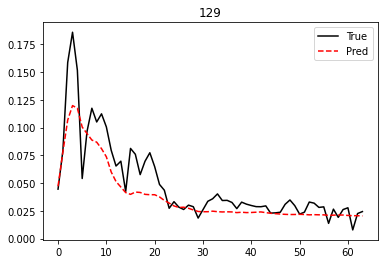

172


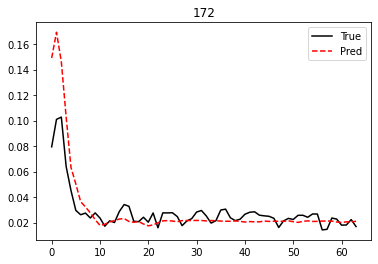

215


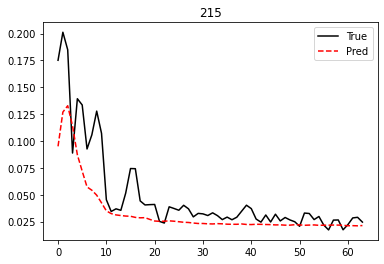

258


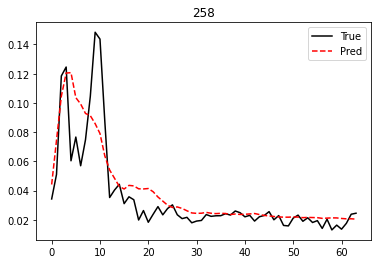

301


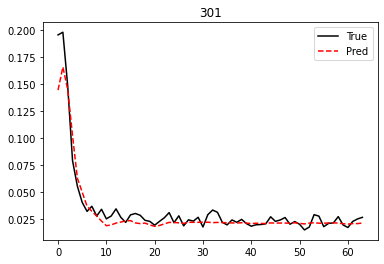

344


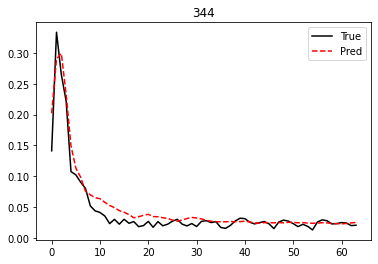

387


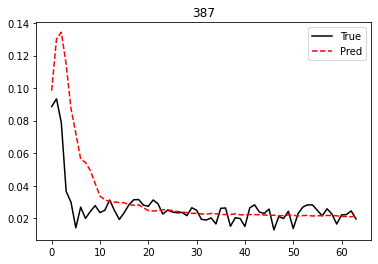

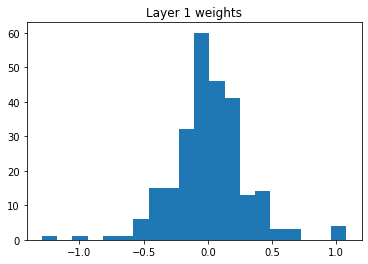

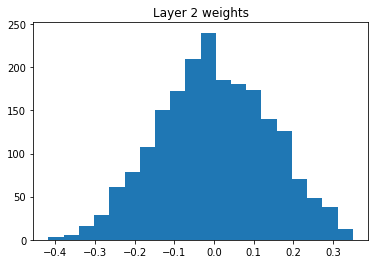

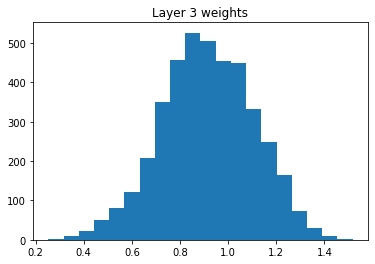

training took 243.867820165 seconds


In [ ]:
import time
start = time.perf_counter()

n_leaps = 20
epochs_per_leap = 60
batch_size = 128
shuffle = True
plot_weights = True
test_indices = np.arange(0,test_len,test_len//9)
test_indices = test_indices.astype(int)
verbosity = 1

domain = np.arange(0,output_dim)

def iqr(x):
    q75, q25 = np.percentile(x, [75 ,25])
    return q75 - q25


for leap in range(n_leaps):
    print('-'*50)
    print('Leap',leap)
    history = model.fit(X_train,Y_train,batch_size=batch_size,epochs=epochs_per_leap,verbose=verbosity,validation_data=(X_test,Y_test), sample_weight=sample_weighting)
    figLoss, axLoss = plt.subplots()
    plt.plot(history.epoch,history.history['loss'],label='Loss')
    plt.plot(history.epoch,history.history['val_loss'],label='Val. Loss')
    axLoss.set_yscale('log')
    plt.title('Losses')
    plt.legend()
    plt.show()
    # descr = 'addit'
    suffix = '_Losses.png'
    #plt.savefig('/content/drive/My Drive/essentia2keras/' + descr + suffix)
    
    print(f"Loss median = { np.median(history.history['loss']) }")
    print(f"Loss width = {iqr(history.history['loss'])}")
    print(f"Val. Loss median = {np.median(history.history['val_loss'])}")
    print(f"Val. Loss width = {iqr(history.history['val_loss'])}")
    
    suffix = '_Test.png'
    for i in test_indices:
        print(i)
        fig, ax = plt.subplots()
        plt.plot(domain,Y_test[i],ls='-',c='k',label='True')
        # why not just "X_test[i]" rather than "X_test[i].reshape(1,input_dim)).flatten()"?
        plt.plot(domain,model.predict(X_test[i].reshape(1,input_dim)).flatten(),ls='--',c='r',label='Pred') 
        plt.title(i)
        plt.legend()
        plt.show()
        #plt.savefig('/content/drive/My Drive/essentia2keras/' + descr + str(i) + suffix)
    

    if plot_weights:
        weights = model.trainable_weights
        k = 0
        suffix = '.png'
        for w in weights:
            if 'kernel' in w.name:
                k+=1
                plt.figure()
                plt.hist(w.numpy().flatten(), bins=20)
                plt.title(f'Layer {k} weights')
                plt.show()
                #plt.savefig('/content/drive/My Drive/essentia2keras/' + descr + f'Layer {k} weights' + suffix)



end = time.perf_counter()  
print(f'training took {end - start} seconds')          

tf.Tensor(0.0005869537, shape=(), dtype=float32)


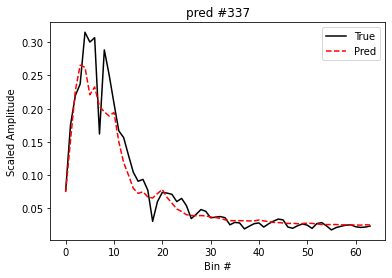

In [ ]:
i = 337
plt.plot(domain,Y_test[i],ls='-',c='k',label='True')
prediction = model.predict(X_test[i].reshape(1,input_dim)).flatten()
plt.plot(domain,prediction,ls='--',c='r',label='Pred') 
plt.legend()
title = f'pred #{i}'
plt.title(title)
plt.xlabel('Bin #')
plt.ylabel('Scaled Amplitude')
print(tf.keras.metrics.mean_squared_error(Y_test[i], prediction))

plt.savefig(f'/content/drive/My Drive/essentia2keras/{title}')



In [ ]:
model.save(f'/content/drive/My Drive/essentia2keras/{descr}_{ann_suffix}.h5', save_format='h5')